# High-Frequency Effects and Modelling on FX Market in Response to US Macroeconomic Data Releases

## Steps:
1. <span style="color:green">Research and Planning
    * <span style="color:green">Define clear research goals and objectives
    * <span style="color:green">Decide on macroeconomic events and FX pairs</span>
2. <span style="color:green">Literature Review
    * <span style="color:green">Review past papers
    * <span style="color:green">Identify gaps (model that does stress testing, probability w/ price range, capturing retracement/correction)<span style="color:green">
3. <span style="color:green">Data Collection and Processing
    * <span style="color:green">Identify data sources
    * <span style="color:green">Collect FX pairs (date, minute interval, open, low, high, close)
    * <span style="color:green">Collect macroeconomic events (date, expected value, actual value)
    * <span style="color:green">Merge datasets
    * <span style="color:green">Keep only data with the macro events (not whole month but only on data releases)
    * <span style="color:green">Do some analysis for data dimensionality (e.g., analysis whether to keep 10 minutes before and 10 minutes after only of the data release)</span>  
4. <span style="color:green">Exploratory Analysis
    * <span style="color:green">Feature importance (which macro event brings more volume)
    * <span style="color:green">Barchart with 6 double bars for each event how many events (expected == actual) vs (expected != actual) and what is their volatility difference.
    * <span style="color:green">Variance before/on/after the events 
        * <span style="color:green">Volatility but also min and max (before 5 min - on the minute - after 10 minutes). For min/max (var) for example find the min and max for all these 3 ranges. For volatility calculate the average of these 3 

5. <span style="color:red">Model Development
    * Create some probabilistic TS model based on historical data
    * Create a class/function to take input of a pair, expected value of macro data, and minute after event to give some price 
6. <span style="color:red">Backtesting and Market Simulation
    * KPIs and statistical measurement of model on test data (can be same as past)
    * Future event test (already known)
range and classification with confidence interval
7. <span style="color:red">Results and Discusion
    * Interpret market reactions to economic data
    * Compare model accuracy with benchmarks</span>

----------------------

# <span style="color:blue">Libraries</span>

In [1]:
# Libraries for data fetching
from polygon import RESTClient

# Libraries for data analysis
import pandas as pd
import numpy as np
import math
from IPython.display import display

# Libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# Libraries for time handling and warnings
import time  
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Libraries for statistical modeling
from arch import arch_model
from scipy.stats import jarque_bera

# Libraries for feature important, splitting, normalizing data and KPIs (metrics)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Libraries for ANN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import backend as K

C:\Users\modio\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


----------------------

# <span style="color:blue">Data Retrieval</span>

* Data Collection FX pair tickers (symbols) for **Polygon.io**:
    * **USD/EUR** 🠆 C:USD/EUR
    * **USD/GBP** 🠆 C:USD/GBP
    * **USD/CNY** 🠆 C:USD/CHF  
    
    
* Macroeconomic events **Bloomberg Terminal (KCL)** (macro_data_bloomberg.csv):
    * **INTR** (every 6-weeks)
    * **CPI** (MoM)
    * **GDP** (QoQ)
    * **PCE** (MoM)
    * **UNRATE** (MoM)
    * **PMI** (MoM)

In [2]:
def polygon_get_fx_data(fx_pair, interval, start_date, end_date, api_key='0GbCWQKVtPfEMJvPmc1n50psE3zsW1c8'):
    """
    Retrieve historical FX data from Polygon.io.

    Parameters:
    - interval (str): The interval for the data ('1m', '5m', '1h', '1d').
    - start_date (str): The start date in 'YYYY-MM-DD' format.
    - end_date (str): The end date in 'YYYY-MM-DD' format.
    - api_key (str): Polygon.io API key.

    Returns:
    - pd.DataFrame: A DataFrame containing historical USD/CNY forex data.
    """
    try:
        # Bring the fx pair ticker to Polygon's format
        fx_pair_polygon_formated = "C:" + str(fx_pair)

        client = RESTClient(api_key)

        # Request data
        data_request = client.get_aggs(
            ticker=fx_pair_polygon_formated, 
            multiplier=1, 
            timespan=interval,
            from_=start_date, 
            to=end_date
        )
    
        # Convert response to DataFrame
        df = pd.DataFrame(data_request)
        
        # Check if data is returned
        if df.empty:
            print("No data found.")
            return None

        # Convert timestamp to datetime format and set Datetime as an index
        df["Datetime"] = pd.to_datetime(df["timestamp"], unit="ms")
        df.set_index("Datetime", inplace=True)
        
        # Drop columns not needed
        df = df.drop(columns=["otc", "transactions", "timestamp"])
        
        # Rename columns to align with yf for the feature engineering and merging later on
        df = df.rename(columns={"high": "High", "low": "Low", "close": "Adj Close", "volume": "Volume"})
        df = df.rename_axis(f'{fx_pair}', axis=1)
        
        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None
        
        
def fetch_and_combine_fx_data(macro_df, pair):
    """
    Fetches and combines minute-level FX data for a given pair and list of macro event dates.

    Parameters:
    - macro_df: DataFrame with datetime index representing macro event dates.
    - pair: FX pair symbol (e.g. 'USD/EUR').

    Returns:
    - Combined DataFrame with volatility and price metrics, prefixed by pair.
    """
    # Get index values to list
    macro_dates_list = macro_df.index.strftime("%Y-%m-%d").tolist()
    
    # Initialize empty DataFrame
    data_df = pd.DataFrame()  

    for i, date in enumerate(macro_dates_list):
        fx_data = calculate_volatility(polygon_get_fx_data(pair, "minute", date, date))
        
        # Add pair symbol as a prefix to columns (excluding Datetime)
        fx_data = fx_data.rename(columns={col: f"{pair}_{col}" for col in fx_data.columns if col != "Datetime"})
        
        # Append the retrieved data to the main DataFrame
        data_df = pd.concat([data_df, fx_data])

        # Implement sleep logic for API limitations
        if (i + 1) % 5 == 0:  
            time.sleep(70)
        else:
            time.sleep(2) 

    return data_df


# Read the CSV file retrieved from Bloomberg Terminal        
macro_df = pd.read_csv("data/macro_bloomberg_data.csv")

----------------------

# <span style="color:blue">Data Preprocessing</span>
1. Replace '--' to null
2. DateTime format (some years to 2 digits some 4 e.g., 2025 and 25)
3. Convert to DateTime
4. Replace the % to decimals and convert to float

In [3]:
def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Finds for  '--' values and converts them to NaN. 
    Afterwards, drop rows where Expected and Actual are NaN.
    
    Parameters:
    - df ()
    """
    # Missing values convert from '--' to NaN
    df.replace('--', np.nan, inplace=True)

    # Drop rows where Expected and Actual are missing
    df = macro_df.dropna(subset=["Expected", "Actual"], how="all")
    
    return df



def standardize_datetime_format(df: pd.DataFrame, column_name="Date Time") -> pd.DataFrame:
    """
    Standardizes the Date Time column to the format MM/DD/YYYY HH:MM,
    converts it to a datetime datatype, sets it as the index, and sorts the DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the column to be formatted.
    - column_name (str): The name of the column to standardize.

    Returns:
    - pd.DataFrame: The DataFrame with the standardized datetime format, 
                    set as index, and sorted.
    """
    def fix_date_format(date_str):
        # Try parsing with two-digit year format first
        dt = pd.to_datetime(date_str, format='%m/%d/%y %H:%M', errors='coerce')
        
        # If conversion fails, try four-digit year format
        if pd.isnull(dt):
            dt = pd.to_datetime(date_str, format='%m/%d/%Y %H:%M', errors='coerce')
        
        return dt  # Return as datetime object

    # Apply the function to convert to datetime
    df = df.copy(deep=True)
    df["Datetime"] = df[column_name].astype(str).apply(fix_date_format)
    
    # Drop rows where conversion failed
    df = df.dropna(subset=["Datetime"])
    # Drop previous 'Date Time'
    df.drop(columns=['Date Time'], inplace=True)

    # Convert the column to datetime dtype
    df["Datetime"] = pd.to_datetime(df["Datetime"])

    # Set Date Time as index
    df = df.set_index("Datetime")

    # Sort DataFrame by the Date Time index
    df = df.sort_index()

    return df



def convert_percentage_to_numeric(df: pd.DataFrame, columns=["Expected", "Actual", "Prior"]) -> pd.DataFrame:
    """
    Converts percentage values in specified columns to numerical float values.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing percentage values.
    - columns (list): List of column names to convert.

    Returns:
    - pd.DataFrame: DataFrame with percentage values converted to floats.
    """
    for col in columns:
        df[col] = df[col].astype(str).str.replace('%', '', regex=True).astype(float)
    
    return df



def clean_macro_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Drops the 'Event' column and renames 'Ticker' values to standardized names.

    Parameters:
    - df (pd.DataFrame): The macroeconomic DataFrame.

    Returns:
    - pd.DataFrame: Cleaned DataFrame with renamed tickers.
    """
    
    # Drop the 'Event' column
    df = df.drop(columns=["Event"], errors="ignore")

    # Dictionary mapping for renaming
    ticker_mapping = {
        "UNRATE": "UNRATE",
        "CPI_MoM": "CPI",
        "INTR": "INTR",
        "PCE_MoM": "PCE",
        "GDP_QoQ": "GDP",
        "PMI": "PMI"
    }

    # Rename cols
    df["Ticker"] = df["Ticker"].replace(ticker_mapping)

    return df


def extract_relevant_fx_data(fx_data, macro_df, start, end)-> pd.DataFrame:
    """
    Extracts FX data around each macro event within a specified time window.

    Parameters:
    - fx_data: DataFrame with datetime index containing FX price and volatility data.
    - macro_df: DataFrame with macro event times as index and event metadata.
    - start: Minutes before the event to include.
    - end: Minutes after the event to include.

    Returns:
    - Combined DataFrame of FX data with added macro event details.
    """
    extracted_data = []

    for event_time in macro_df.index:
        start_time = event_time - pd.Timedelta(minutes=start)
        end_time = event_time + pd.Timedelta(minutes=end)

        # Check if any timestamps in the range exist in fx_data
        available_times = fx_data.index[(fx_data.index >= start_time) & (fx_data.index <= end_time)]

        if available_times.empty:  
            continue  # Skip if no matching timestamps exist

        filtered_fx = fx_data.loc[available_times].copy()

        # Add event details from macro_df
        if event_time in macro_df.index:
            filtered_fx["Ticker"] = macro_df.loc[event_time, "Ticker"]
            filtered_fx["Expected"] = macro_df.loc[event_time, "Expected"]
            filtered_fx["Actual"] = macro_df.loc[event_time, "Actual"]
            filtered_fx["Prior"] = macro_df.loc[event_time, "Prior"]
            filtered_fx["Surprise"] = macro_df.loc[event_time, "Surprise"]

        extracted_data.append(filtered_fx)

    # Set Datetime index
    final_df = pd.concat(extracted_data).reset_index()
    final_df = final_df.rename(columns={"index": "Datetime"}).set_index("Datetime")
    # Drop duplicates if they exist
    final_df = final_df[~final_df.index.duplicated(keep="first")]
    
    return final_df


def fill_in_missing_minute(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Duplicates the row at `original_time`, changes its 'Datetime' to `new_time`, 
    appends it to the DataFrame, sorts by datetime, and resets the index.
    
    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame with a 'Datetime' column.
    
    Returns:
    - pd.DataFrame: Updated DataFrame with the new row inserted and sorted by datetime.
    """
    df = dataframe.copy()
    df['Datetime'] = pd.to_datetime(df.index)

    # Locate the row to duplicate
    row_to_copy = df[df['Datetime'] == pd.to_datetime('2023-04-07 13:39:00')].copy()

    # Update datetime in the copied row
    row_to_copy.loc[:, 'Datetime'] = pd.to_datetime('2023-04-07 13:38:00')

    # Append and sort
    df = pd.concat([df, row_to_copy], ignore_index=True)
    df = df.sort_values(by='Datetime').reset_index(drop=True)
    
    # Set datetime as index
    df = df.set_index('Datetime')

    return df

----------------------

# <span style="color:blue">Feature Engineering</span>

In [4]:
def surprise_calculation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the surprise (difference) of Expected vs Actual.
    
    Parameters:
    - df (pd.DataFrame): macro economic data

    Returns:
    - pd.DataFrame: Original dataframe plus the surprise column.
    """
    
    df["Surprise"] = df["Actual"] - df["Expected"]
    return df


def calculate_volatility(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the average volatility dynamically.

    Parameters:
    - df (pd.DataFrame): FX data.

    Returns:
    - pd.DataFrame: The original DataFrame with added 'Volatility', 'Average_Volatility', and 'Volatility_Multiplier' columns.
    """

    if df is None or df.empty:
        print("Error: DataFrame is empty or invalid.")
        return None
    if "Adj Close" in df.columns:
        # Compute Volatility
        df['Volatility'] = np.abs(np.log(df['Adj Close'] / df['Adj Close'].shift(1)))
    else:
        df['Volatility'] = np.abs(np.log(df['Close'] / df['Close'].shift(1)))
        
    # Compute Average Volatility based on each trading day
    df['Average_Volatility'] = df['Volatility'].mean()
    # Compute Volatility Multiplier
    df['Volatility_Multiplier'] = round(df['Volatility'] / df['Average_Volatility'],2)

    return df

------------

# <span style="color:blue">Plotting Functions</span>

In [5]:
########################################################################
################### Event Volatility Time Analysis #####################

def plot_time_differences(time_differences, avg_start, avg_end):
    """
    Plots the distribution of time differences from event timestamps,
    highlighting where the most volatile timeframes begin and end.
    Filters to display only x-axis range from -70 to +70 minutes.
    """
    # Filter values in the desired range
    start_diffs = [diff[0] for diff in time_differences if -70 <= diff[0] <= 70]
    end_diffs = [diff[1] for diff in time_differences if -70 <= diff[1] <= 70]

    # Plot setup
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    # KDE plots for smoother curves
    sns.histplot(start_diffs, bins=50, kde=True, color="royalblue", label="Start Time", alpha=0.5, edgecolor='white')
    sns.histplot(end_diffs, bins=50, kde=True, color="tomato", label="End Time", alpha=0.5, edgecolor='white')

    # Add vertical reference lines
    plt.axvline(avg_start, color="blue", linestyle="--", linewidth=2)
    plt.axvline(avg_end, color="red", linestyle="--", linewidth=2)
    plt.axvline(0, color="black", linestyle="-", linewidth=2)

    # Add text labels with padding
    y_max = plt.ylim()[1]
    plt.text(avg_start + 0.5, y_max * 0.9, f"{avg_start:.0f} min", color="blue", fontsize=12, fontweight="bold")
    plt.text(avg_end + 0.5, y_max * 0.9, f"{avg_end:.0f} min", color="red", fontsize=12, fontweight="bold")
    plt.text(0.6, y_max * 0.9, "Event Time\n(0 min)", color="black", fontsize=12, fontweight="bold")

    # Set plot limits and labels
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.xlim(-20, 20)
    plt.xlabel("Time Difference from Event (in minutes)", fontsize=12, fontweight="bold")
    plt.ylabel("Frequency", fontsize=12, fontweight="bold")
    plt.title("Distribution of Most Volatile 16-Minute Timeframes", fontsize=12, fontweight="bold")
    plt.legend(fontsize=11, frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


###########################################################################
########################### Feature Importance ############################

def plot_event_importance(importance_df):
    """
    Plots the feature importance of macroeconomic events on Volatility.

    Args:
        importance_df (pd.DataFrame): Feature importance dataframe.
    """

    # Plot
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=importance_df, x="Volatility_Impact", y="Event", palette="Blues_r", dodge=False)
    for bar in ax.patches:
        bar.set_height(bar.get_height() * 0.7)
    
    plt.title("Feature Importance of Macroeconomic Events on Volatility", fontsize=12, fontweight='bold')
    plt.xlabel("Importance Score", fontsize=12)
    plt.ylabel("Event", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()

    plt.show()


def plot_event_importance_by_year(importance_df):
    """
    Plots the feature importance of macroeconomic events on Volatility across different years,
    sorted based on 2023 importance.

    Parameters:
    - importance_df (pd.DataFrame): Dataframe with feature importance scores per year.
    """

    # Define colors for each year
    color_palette = {2023: "#1f4b99", 2024: "#2a7ccc", 2025: "#87bfff"}  # Dark blue, blue, light blue

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(
        data=importance_df,
        x="Volatility_Impact",
        y="Event",
        hue="Year",
        palette=color_palette,
        ax=ax
    )

    # Plot customizations
    plt.title("Feature Importance of Macroeconomic Events on Volatility (2023-2025)", fontsize=12, fontweight='bold')
    plt.xlabel("Importance Score", fontsize=12)
    plt.ylabel("Event", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title="Year", fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()

    # Show plot
    plt.show()
    pass


###########################################################################
########################## Correlation Analysis ###########################

def analyze_usd_pairs_correlation(df, macro_df):
    """
    Analyze the correlation between USD pairs around macroeconomic event times.
    
    Parameters:
    - df (pd.DataFrame): FX market data with datetime index.
    - macro_df (pd.DataFrame): Macro event timestamps.
    
    Returns:
    - None, just a plot.
    """
    
    # Selecting only the AdjClose columns for the three currency pairs
    adj_close_data = final_data[['USDEUR_AdjClose', 'USDGBP_AdjClose', 'USDCNH_AdjClose']]

    # Drop any rows with null values
    adj_close_data = adj_close_data.dropna()

    # Compute correlation matrix
    corr_matrix = adj_close_data.corr()

    # Plot heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f")
    plt.title("Correlation Heatmap - AdjClose of Currency Pairs", fontsize=12, fontweight='bold')
    plt.show()
    

###########################################################################
##################### Analysts Expectations vs Actual #####################

def plot_expectations_vs_actual(df: pd.DataFrame):
    # Ensure datetime format and event segmentation
    df = df.reset_index(drop=True)
    df['EventID'] = df.index // 16
    event_blocks = df.groupby('EventID').first()

    # Correctness of predictions
    event_blocks['CorrectPrediction'] = event_blocks['Expected'] == event_blocks['Actual']

    # Count correct and incorrect predictions per Ticker
    correct_counts = event_blocks[event_blocks['CorrectPrediction']].groupby('Ticker').size()
    incorrect_counts = event_blocks[~event_blocks['CorrectPrediction']].groupby('Ticker').size()

    # Fill missing tickers with 0
    all_tickers = set(event_blocks['Ticker'].unique())
    correct_counts = correct_counts.reindex(all_tickers, fill_value=0)
    incorrect_counts = incorrect_counts.reindex(all_tickers, fill_value=0)

    # Sort by correct prediction counts
    sorted_tickers = correct_counts.sort_values(ascending=False).index
    correct_counts = correct_counts[sorted_tickers]
    incorrect_counts = incorrect_counts[sorted_tickers]

    # Plot
    x = range(len(sorted_tickers))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    bars1 = ax.bar(x, correct_counts, width, label='Expected == Actual', color='#1f4b99')
    bars2 = ax.bar([i + width for i in x], incorrect_counts, width, label='Expected ≠ Actual', color='#87bfff')

    # Add value labels above bars
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.2, str(int(height)),
                ha='center', va='bottom', fontsize=8)

    # Customize plot
    ax.set_xlabel('Macro Event Type', fontsize=10)
    ax.set_ylabel('Number of Events', fontsize=10)
    ax.set_title('Prediction Accuracy per Macro Event Type', fontsize=12, fontweight='bold')
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(sorted_tickers, fontsize=9)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Force integer y-ticks
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(False)  # Remove grid
    ax.legend(fontsize=9)  # Add legend
    plt.tight_layout(pad=1)
    plt.show()
    
    
###########################################################################
##################### Time_Window: Before, On, After ######################

def plot_fx_event_patterns(results_dict, fx_pairs):
    """
    Plots volatility and absolute return trends (Before, On, After) for each FX pair.

    Parameters:
    - results_dict: output from analyze_event_windows()
    - fx_pairs: list of FX pair keys (e.g. 'USDEUR_AdjClose')

    Displays 2 charts per FX pair: one for volatility, one for absolute return.
    """
    ordered_windows = ['Before', 'On', 'After']
    fig, axes = plt.subplots(len(fx_pairs), 2, figsize=(12, 8 ))

    for i, pair in enumerate(fx_pairs):
        df = results_dict[pair].copy()
        df['Time_Window'] = pd.Categorical(df['Time_Window'], categories=ordered_windows, ordered=True)
        grouped = df.groupby('Time_Window').mean(numeric_only=True)

        # Volatility trend
        axes[i, 0].plot(grouped.index, grouped['Average_Volatility'], marker='o', color='blue')
        axes[i, 0].set_title(f'{pair.replace("_AdjClose", "")}: Volatility Trend', fontweight='bold')
        axes[i, 0].set_ylabel('Volatility', fontweight='bold', color='blue')


        # Absolute return trend
        axes[i, 1].plot(grouped.index, grouped['Average_Absolute_Return'], marker='o', color='green')
        axes[i, 1].set_title(f'{pair.replace("_AdjClose", "")}: Absolute Return Trend', fontweight='bold')
        axes[i, 1].set_ylabel('Absolute Return', fontweight='bold', color='green')

    plt.tight_layout()
    plt.show()
        
###########################################################################
##################### Volume of Currencies Per Year ######################
    
def plot_currency_volume_per_year(df: pd.DataFrame):
    """
    Plots grouped bar charts of total volume per year with separate bars for each currency.

    Parameters:
    - df: DataFrame with datetime index and volume data.
    """
    # Ensure index is datetime and extract year
    df.index = pd.to_datetime(df.index, dayfirst=True)
    df['Year'] = df.index.year
    
    # Rename Columns
    volume_cols = {
        'USDEUR_Volume': 'EUR',
        'USDGBP_Volume': 'GBP',
        'USDCNH_Volume': 'CHNY'
    }

    # Aggregate volume per year
    volume_data = df.groupby('Year')[[*volume_cols.keys()]].sum()
    volume_data.rename(columns=volume_cols, inplace=True)

    # Colors
    bar_colors = ["#1f4b99", "#2a7ccc", "#87bfff"]
    
    # Plot
    fig, ax = plt.subplots()
    bar_width = 0.15
    years = volume_data.index
    currencies = volume_data.columns
    x = range(len(years))

    for i, (currency, color) in enumerate(zip(currencies, bar_colors)):
        ax.bar(
            [xi + i * bar_width for xi in x],
            volume_data[currency],
            width=bar_width,
            color=color,
            label=currency
        )

    ax.set_xticks([xi + bar_width for xi in x])
    ax.set_xticklabels(years)
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Volume')
    ax.set_title('Currency Volume per Year')
    ax.legend(title='Currency')
    plt.tight_layout()
    plt.show()
    
    
###########################################################################
################# Short Term Volatility of Pair per Year ##################

def plot_short_term_vol_per_year(df: pd.DataFrame):
    """
    Plots a 3x3 grid of bar charts showing volatility summaries for 3 FX pairs across 3 years (2023–2025).

    Each bar chart displays:
    - '1-min': Volatility at 6th minute of each 16-minute event
    - '5-min': Max avg of rolling 5-min windows (1–5, 6–10, 11–15)
    - '16-min': Full average over the 16-minute event
    """
    
    # Add Year column
    df.index = pd.to_datetime(df.index, dayfirst=True)
    df['Year'] = df.index.year
    
    years = [2023, 2024, 2025]
    pairs = {
        'USDGBP': 'USDGBP_Volatility',
        'USDEUR': 'USDEUR_Volatility',
        'USDCNH': 'USDCNH_Volatility'
    }

    fig, axs = plt.subplots(3, 3, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    for row_idx, (pair, col) in enumerate(pairs.items()):
        for col_idx, year in enumerate(years):
            data = df[df['Year'] == year][[col]].reset_index(drop=True)
            if len(data) < 16:
                continue

            one_min, five_min, full_avg = [], [], []
            num_events = len(data) // 16

            for i in range(num_events):
                block = data[col].iloc[i*16:(i+1)*16].reset_index(drop=True)
                if len(block) < 16:
                    continue

                one_min.append(block.iloc[5])
                rolling = [block.iloc[start:start+5].mean() for start in [0, 5, 10] if start + 5 <= len(block)]
                five_min.append(max(rolling) if rolling else np.nan)
                full_avg.append(block.mean())

            avg_vols = [np.mean(one_min), np.mean(five_min), np.mean(full_avg)]

            ax = axs[row_idx, col_idx]
            ax.bar(['1-min', '5-min', '16-min'], avg_vols, color="#1f4b88", width=0.33)
            ax.set_title(f'{pair} - {year}', fontsize=12, fontweight='bold')
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)
            ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
            ax.grid(False)

    plt.tight_layout()
    plt.show()
    
    
###########################################################################
################# Distribution Analysis of Macro Events ###################
    
def plot_actual_distributions(df, value_col='Actual'):
    """
    Plot histograms with KDE lines for the distribution of a specified value column,
    grouped by a categorical column (e.g. macroeconomic event tickers).

    Parameters:
    - df: DataFrame containing the data
    - value_col: name of the column with numeric values (default 'Actual')
    - bins: number of histogram bins (default 20)
    """

    tickers = df['Ticker'].unique()
    num_tickers = len(tickers)
    cols = 2
    rows = int(np.ceil(num_tickers / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(14, rows * 3.5))
    axs = axs.flatten()

    for i, ticker in enumerate(tickers):
        data = df[df['Ticker'] == ticker][value_col].dropna()
        sns.histplot(data, kde=True, ax=axs[i], bins=10, color='steelblue')

        # Enhance KDE line
        for line in axs[i].lines:
            line.set_linewidth(2.5)
            line.set_color('blue')

        axs[i].set_title(f'Distribution of {value_col} - {ticker}', fontsize=14, fontweight='bold')
        axs[i].set_xlabel(f'{value_col} Value')
        axs[i].set_ylabel('Observations')
        axs[i].grid(True)

    # Hide any extra axes
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
    
###########################################################################
################ Subplots for 6 distinct events per pair ##################
    
def plot_all_events_across_pairs(results_dict):
    """
    Plot 6 rows (1 per event) × 3 columns (1 per FX pair).
    
    Parameters:
    - results_dict: dict returned from training loop
      Must contain keys 'USDEUR', 'USDGBP', 'USDCNH'
      Each entry should include 'preds', 'actuals', 'inputs', 'price_scaler', 'features', 'events'
    """
    fx_pairs = ['USDEUR', 'USDGBP', 'USDCNH']
    all_events = ['CPI', 'GDP', 'INTR', 'PCE', 'PMI', 'UNRATE']

    fig, axes = plt.subplots(len(all_events), len(fx_pairs), figsize=(18, 18), sharex=True)
    
    for row, event in enumerate(all_events):
        for col, pair in enumerate(fx_pairs):
            ax = axes[row, col]
            pair_data = results_dict[pair]

            # If this event doesn't exist for this pair, hide the plot
            if event not in pair_data['events']:
                ax.set_visible(False)
                continue

            event_idx = pair_data['events'].index(event)
            pred_scaled = pair_data['preds'][event_idx]
            actual_scaled = pair_data['actuals'][event_idx]
            demo_input = pair_data['inputs'][event_idx]
            price_scaler = pair_data['price_scaler']
            features = pair_data['features']

            # Inverse transform
            pred_real = price_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
            actual_real = price_scaler.inverse_transform(actual_scaled.reshape(-1, 1)).flatten()

            # Recover last known price from input
            last_idx = features.index(f'{pair}_AdjClose')
            last_known = price_scaler.inverse_transform([[demo_input[0, -1, last_idx]]])[0, 0]
            pred_real = np.concatenate([[last_known], pred_real])
            actual_real = np.concatenate([[last_known], actual_real])

            # Plot
            ax.plot(range(-1, 11), actual_real, marker='o', label='Actual')
            ax.plot(range(-1, 11), pred_real, marker='x', label='Predicted')
            ax.axvline(0, linestyle='--', color='gray', label='Event Time')

            # Y-axis padding 
            combined = np.concatenate([actual_real, pred_real])
            y_min, y_max = combined.min(), combined.max()
            y_range = y_max - y_min
            buffer = 0.25 * y_range
            ax.set_ylim(y_min - buffer, y_max + buffer)

            if row == 0:
                ax.set_title(pair, fontsize=12, fontweight='bold')
            if col == 0:
                ax.set_ylabel(event, fontsize=12, fontweight='bold')

            if row == 0 and col == 0:
                ax.legend(fontsize=8)

            ax.tick_params(labelsize=9)
            ax.grid(False)

    fig.suptitle("FX Forecasts by Event and Pair (T-1 to T+10)", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
###########################################################################
############# Event: Price prediction (Garch & LSTM) & Bounds ###############
    
def plot_fx_forecasts(df, actual_prices):
    """
    Plots LSTM, GARCH, and Monte Carlo bounds from the combined FX forecast DataFrame.

    Args:
        df (pd.DataFrame): Combined output from combine_fx_event_predictions
        actual_prices (list or np.array): Actual FX prices over the same timestamps
    """
    times = df.index
    lstm = df['LSTM_Price']
    garch = df['GARCH_Price']
    bounds = df['MC_Bounds'].apply(lambda x: x if isinstance(x, tuple) else (None, None))
    lower_bounds = bounds.apply(lambda x: x[0])
    upper_bounds = bounds.apply(lambda x: x[1])

    # Calculate y-axis limits with 5% adjustment (zoom out)
    all_prices = pd.concat([lstm, garch, pd.Series(actual_prices, index=times), lower_bounds, upper_bounds])
    min_y = all_prices.min()
    max_y = all_prices.max()
    y_padding = 0.1 * (max_y - min_y)
    y_lower = min_y - y_padding
    y_upper = max_y + y_padding

    # Plotting
    plt.figure(figsize=(13, 6))
    plt.plot(times, lstm, label='LSTM Forecast', color='blue', linestyle='--', linewidth=2)
    plt.plot(times, garch, label='GARCH Forecast', color='orange', linestyle='--', linewidth=2)
    plt.plot(times, actual_prices, label='Actual Price', color='black',  linewidth=2, marker='o', markersize=4)

    # Monte Carlo bounds as shaded region
    plt.fill_between(times, lower_bounds, upper_bounds, color='red', alpha=0.08, label='MC Bounds')

    # Draw vertical line at the same time as the first non-null MC_Bounds
    event_time_candidates = df[df['MC_Bounds'].apply(lambda x: isinstance(x, tuple) and x[0] is not None)].index

    if not event_time_candidates.empty:
        event_time = event_time_candidates[1]
        plt.axvline(x=event_time, color='black', linestyle=':', linewidth=2, label='Event Time')

    # Formatting
    fx_pair = df['FX_Pair'].iloc[0]
    event = df['Ticker'].iloc[0]
    plt.title(f"FX Forecast for {fx_pair} — Event: {event}", fontsize=16, weight='bold')
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("FX Price", fontsize=12)
    plt.ylim(y_lower, y_upper)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

----------------------

# <span style="color:blue">Data Analysis</span>

In [33]:
###########################################################################
######################## Most Volatile Timeframe ##########################

def find_most_volatile_16min(df, filtered_macro_df):
    """
    Finds the most volatile 16-minute timeframe for each event date in filtered_macro_df.

    Parameters:
        - df (pd.DataFrame): FX data with Datetime index.
        - filtered_macro_df (pd.DataFrame): Macro data with event timestamps as index.

    Returns:
        - dict: Most volatile timeframes for each event.
        - float: Average time difference for start and end times.
    """
    
    # Store results
    most_volatile_times = {}
    time_differences = []

    # Check if required volatility columns exist
    required_columns = ["USDEUR_Volatility", "USDGBP_Volatility", "USDCNH_Volatility"]
    
    # Compute combined average volatility
    df["Average_Volatility"] = df[required_columns].mean(axis=1)

    # Loop through each event in filtered_macro_df
    for event_date in filtered_macro_df.index:
        event_date = pd.to_datetime(event_date)

        # Filter only data for the event date
        group = df[df.index.date == event_date.date()]
        if group.empty: continue

        # Compute rolling sum of average volatility
        rolling_volatility = group["Average_Volatility"].rolling(window=7, min_periods=7).sum()
        # Get the time with the highest volatility over the exact 16-minute window
        end_time = rolling_volatility.idxmax()
        if pd.isna(end_time): continue
        start_time = end_time - timedelta(minutes=15)

        # Compute time difference from event timestamp. Convert to minutes
        diff_start = (start_time - event_date).total_seconds() / 60
        diff_end = (end_time - event_date).total_seconds() / 60

        # Store results
        most_volatile_times[event_date] = (start_time, end_time)
        time_differences.append((diff_start, diff_end))

    # Compute average time differences
    avg_diff_start = math.floor(np.mean([diff[0] for diff in time_differences]))
    avg_diff_end = math.floor(np.mean([diff[1] for diff in time_differences]))

    print(f"\nTotal events analyzed: {len(most_volatile_times)}")
    print(f"Average Time Difference: {avg_diff_start} min (start) | {avg_diff_end} min (end)")

    return most_volatile_times, avg_diff_start,  avg_diff_end, time_differences


###########################################################################
###################### Macro Data Event Importance ########################

def compute_event_importance(df):
    """
    Computes the importance of macroeconomic events on Volatility.

    Parameters:
    - df (pd.DataFrame): Dataset containing macro events and FX market data.

    Returns:
    - pd.DataFrame: Dataframe with feature importance scores.
    """

    # One-Hot Encode Event Types
    events = pd.get_dummies(df["Ticker"])  
    df = pd.concat([df, events], axis=1)

    # Define target variable (Volatility Impact)
    df["Volatility_Impact"] = df[["USDEUR_VolatilityMultiplier", 
                                  "USDGBP_VolatilityMultiplier", 
                                  "USDCNH_VolatilityMultiplier"]].mean(axis=1)

    # Features = Event Types
    X = df[events.columns]
    y_volatility = df["Volatility_Impact"]

    # Train Random Forest Regressor
    rf_volatility = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_volatility.fit(X, y_volatility)

    # Compute feature importance
    importance_df = pd.DataFrame({
        "Event": X.columns,
        "Volatility_Impact": rf_volatility.feature_importances_
    }).sort_values(by="Volatility_Impact", ascending=False)

    return importance_df


def compute_event_importance_by_year(df, years=[2023, 2024, 2025]):
    """
    Computes the importance of macroeconomic events on Volatility for specified years.

    Parameters:
    - df (pd.DataFrame): Dataset containing macro events and FX market data.
    - years (list): List of years to analyze.

    Returns:
    - pd.DataFrame: Dataframe with feature importance scores for each year.
    """

    importance_list = []

    for year in years:
        df_year = df[df.index.year == year].copy()

        if df_year.empty:
            continue

        # One-Hot Encode Event Types
        events = pd.get_dummies(df_year["Ticker"])  
        df_year = pd.concat([df_year, events], axis=1)

        # Define target variable (Volatility Impact)
        df_year["Volatility_Impact"] = df_year[["USDEUR_VolatilityMultiplier", "USDGBP_VolatilityMultiplier", "USDCNH_VolatilityMultiplier"]].mean(axis=1)

        # Define features (Event Types)
        X = df_year[events.columns]
        y_volatility = df_year["Volatility_Impact"]

        # Train Random Forest Regressor
        rf_volatility = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_volatility.fit(X, y_volatility)

        # Store feature importance
        importance_df = pd.DataFrame({
            "Event": X.columns,
            "Volatility_Impact": rf_volatility.feature_importances_,
            "Year": year
        })

        importance_list.append(importance_df)

    # Combine all years
    combined_importance = pd.concat(importance_list)

    # Sort by 2023 event importance
    sort_order = combined_importance[combined_importance["Year"] == 2024].sort_values(by="Volatility_Impact", ascending=False)["Event"]
    combined_importance["Event"] = pd.Categorical(combined_importance["Event"], categories=sort_order, ordered=True)

    return combined_importance

###########################################################################
################ Analysis Before, On and After the event ##################

def analyze_event_windows(df):
    """
    Analyzes return and volatility across 'Before', 'On', and 'After' windows 
    for each macro event and FX pair.

    Parameters:
    - df: DataFrame with macro-labeled FX data, 16 rows per event.

    Returns:
    - Dictionary of DataFrames, one per FX pair, with grouped stats by Event Type and Time Window.
    """
    df = df.reset_index(drop=True)

    # Assign unique event IDs and minute index within each event block
    df['EventID'] = df.index // 16
    df['MinuteIndex'] = df.groupby('EventID').cumcount()
    df['Event_Type'] = df.groupby('EventID')['Ticker'].transform('first')
    
    # Label time window based on minute index
    def window_label(i):
        if i <= 4:
            return 'Before'
        elif i == 5:
            return 'On'
        else:
            return 'After'

    df['Time_Window'] = df['MinuteIndex'].apply(window_label)

    fx_pairs = ['USDEUR_AdjClose', 'USDGBP_AdjClose', 'USDCNH_AdjClose']
    results = {}

    for pair in fx_pairs:
        return_col = f'{pair}_Return'
        vol_col = f'{pair.replace("AdjClose", "Volatility")}'

        # Calculate percentage returns per EventID
        df[return_col] = df.groupby('EventID')[pair].pct_change().fillna(0)

        # Calculate rolling volatility (standard deviation of returns) per EventID
        df[vol_col] = (
            df.groupby('EventID')[return_col]
            .rolling(window=5, min_periods=1)
            .std()
            .reset_index(level=0, drop=True)
            .fillna(0)
        )

        # Group and calculate return metrics
        returns = df.groupby(['Event_Type', 'Time_Window'])[return_col].agg(
            Minimum_Return='min',
            Maximum_Return='max',
            Average_Absolute_Return=lambda x: x.abs().mean()
        )

        # Group and calculate average volatility
        volatility = df.groupby(['Event_Type', 'Time_Window'])[vol_col].mean().to_frame(name='Average_Volatility')

        # Combine into one result per FX pair
        results[pair] = returns.join(volatility).reset_index()

    # Sort each FX pair's result by Event Type and ordered Time Window
    ordered_window = ['Before', 'On', 'After']
    for pair in results:
        df_pair = results[pair]
        df_pair['Time_Window'] = pd.Categorical(df_pair['Time_Window'], categories=ordered_window, ordered=True)
        results[pair] = df_pair.sort_values(['Event_Type', 'Time_Window']).reset_index(drop=True)

    return results


###########################################################################
################# Macro Events Volatility Summary Table ###################

def format_macro_summary_table(results_dict):
    """
    Builds a summary DataFrame with metrics similar to Screenshot 1 for each FX pair.

    Columns:
    - ANNOUNCEMENT (Event Type)
    - COUNTRY (inferred from event origin)
    - COEFF: average volatility 'On' (as proxy for impact)
    - ROB.T: t-statistic proxy = On / Before volatility (relative jump size)
    - %JUMP: percentage change in volatility from Before to On
    - %DAY: volatility share = On / (Before + After)
    """
    formatted_dfs = []

    for pair_name, df in results_dict.items():
        df = df.copy()
        pivoted = df.pivot(index='Event_Type', columns='Time_Window')

        # Extract relevant values
        on_vol = pivoted['Average_Volatility']['On']
        before_vol = pivoted['Average_Volatility']['Before']
        after_vol = pivoted['Average_Volatility']['After']

        # Calculated metrics
        coeff = on_vol
        rob_t = on_vol / before_vol
        pct_jump = 100 * (on_vol - before_vol) / before_vol
        pct_day = 100 * on_vol / (before_vol + after_vol)

        summary_df = pd.DataFrame({
            'EVENT': on_vol.index,
            "COUNTRY": 'US',  # placeholder
            'COEFF': round(coeff,5),
            'ROB.T': round(rob_t,2),
            '%JUMP': round(pct_jump,2),
            '%DAY': round(pct_day,2),
            'PAIR': pair_name.replace('_AdjClose', '')
        }).reset_index(drop=True)

        formatted_dfs.append(summary_df)
    
    return pd.concat(formatted_dfs, ignore_index=True)

###########################################################################
#################### Macro Events Stats Computation #######################

def compute_grouped_actual_stats(df, value_col='Actual'):
    """
    Compute descriptive statistics (mean, median, std, Jarque-Bera, observations)
    for a numeric column grouped by Ticker.

    Significance stars (*** only) are shown for Jarque-Bera test if p-value < 0.01.

    Parameters:
    - df: DataFrame with macroeconomic event data
    - value_col: name of the numeric column to compute stats on

    Returns:
    - stats_df: formatted statistics table with Ticker columns and statistic rows
    """

    grouped = df.groupby('Ticker')[value_col]

    # Compute stats
    stats = {
        'Mean': grouped.mean(),
        'Median': grouped.median(),
        'SD': grouped.std(),
        'Jarque-Bera': grouped.apply(lambda x: jarque_bera(x.dropna())[0]),
        'JB p-value': pd.Series(0.01, index=grouped.groups.keys()),
        'Observations': grouped.count()
    }

    # Build DataFrame
    stats_df = pd.DataFrame(stats).T

    # Format Jarque-Bera row using fixed p-value
    stats_df.loc['Jarque-Bera'] = [
        f"{stats_df.loc['Jarque-Bera', col]:.3f}"
        for col in stats_df.columns
    ]

    # Drop JB p-value row since it's not needed
    stats_df = stats_df.drop(index='JB p-value')

    # Round numerical values
    for row in ['Mean', 'Median', 'SD']:
        stats_df.loc[row] = stats_df.loc[row].astype(float).round(3)

    # Ensure observation counts are integers
    stats_df.loc['Observations'] = stats_df.loc['Observations'].astype(int)

    # Sort by descending number of observations
    stats_df = stats_df.loc[:, stats_df.loc['Observations'].sort_values(ascending=False).index]

    return stats_df

----------------------

# <span style="color:blue">Macro data preprocessed</span>

In [7]:
# Macroeconomics DataFrame
macro_df = clean_macro_dataframe(
                surprise_calculation(
                    convert_percentage_to_numeric(
                        standardize_datetime_format(
                            handle_missing_values(macro_df)
                        )
                   )
                )
           )

# Getting data for the past 2 years
filtered_macro_df = macro_df[macro_df.index >= "2023-03-10"].copy()

filtered_macro_df

,Ticker,Expected,Actual,Prior,Surprise
Datetime,,,,,
2023-03-10 13:30:00,UNRATE,3.4,3.6,3.40,0.2
2023-03-14 12:30:00,CPI,0.4,0.4,0.50,0.0
2023-03-22 18:00:00,INTR,5.0,5.0,4.75,0.0
2023-03-30 13:30:00,GDP,2.7,2.6,2.70,-0.1
2023-03-31 13:30:00,PCE,0.3,0.3,0.60,0.0
...,...,...,...,...,...
2025-01-29 19:00:00,INTR,4.5,4.5,4.50,0.0
2025-01-30 13:30:00,GDP,2.6,2.3,3.10,-0.3
2025-01-31 13:30:00,PCE,0.3,0.3,0.10,0.0


#  <span style="color:blue"> Macro Data Seasonality report </span>

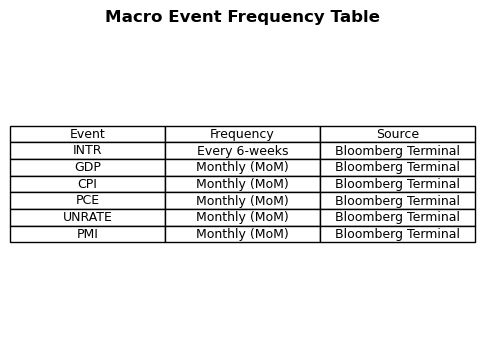

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis("tight")
ax.axis("off")
table_data = [["INTR", "Every 6-weeks", "Bloomberg Terminal"],
              ["GDP", "Monthly (MoM)", "Bloomberg Terminal"],
              ["CPI", "Monthly (MoM)", "Bloomberg Terminal"],
              ["PCE", "Monthly (MoM)", "Bloomberg Terminal"],
              ["UNRATE", "Monthly (MoM)", "Bloomberg Terminal"],
              ["PMI", "Monthly (MoM)", "Bloomberg Terminal"]]

table = ax.table(cellText=table_data, colLabels=["Event", "Frequency", "Source"], cellLoc="center", loc="center")

# Display the table
plt.title("Macro Event Frequency Table", fontsize=12, fontweight='bold')
plt.show()

In [9]:
# Stats of Macro Events
compute_grouped_actual_stats(filtered_macro_df)

,CPI,UNRATE,GDP,PCE,PMI,INTR
Mean,0.254,3.863,2.722,0.2,49.464,5.234
Median,0.25,3.85,2.8,0.2,49.5,5.5
SD,0.169,0.252,1.133,0.135,1.521,0.37
Jarque-Bera,0.254,1.132,1.879,0.713,0.228,2.955
Observations,24,24,23,23,22,16


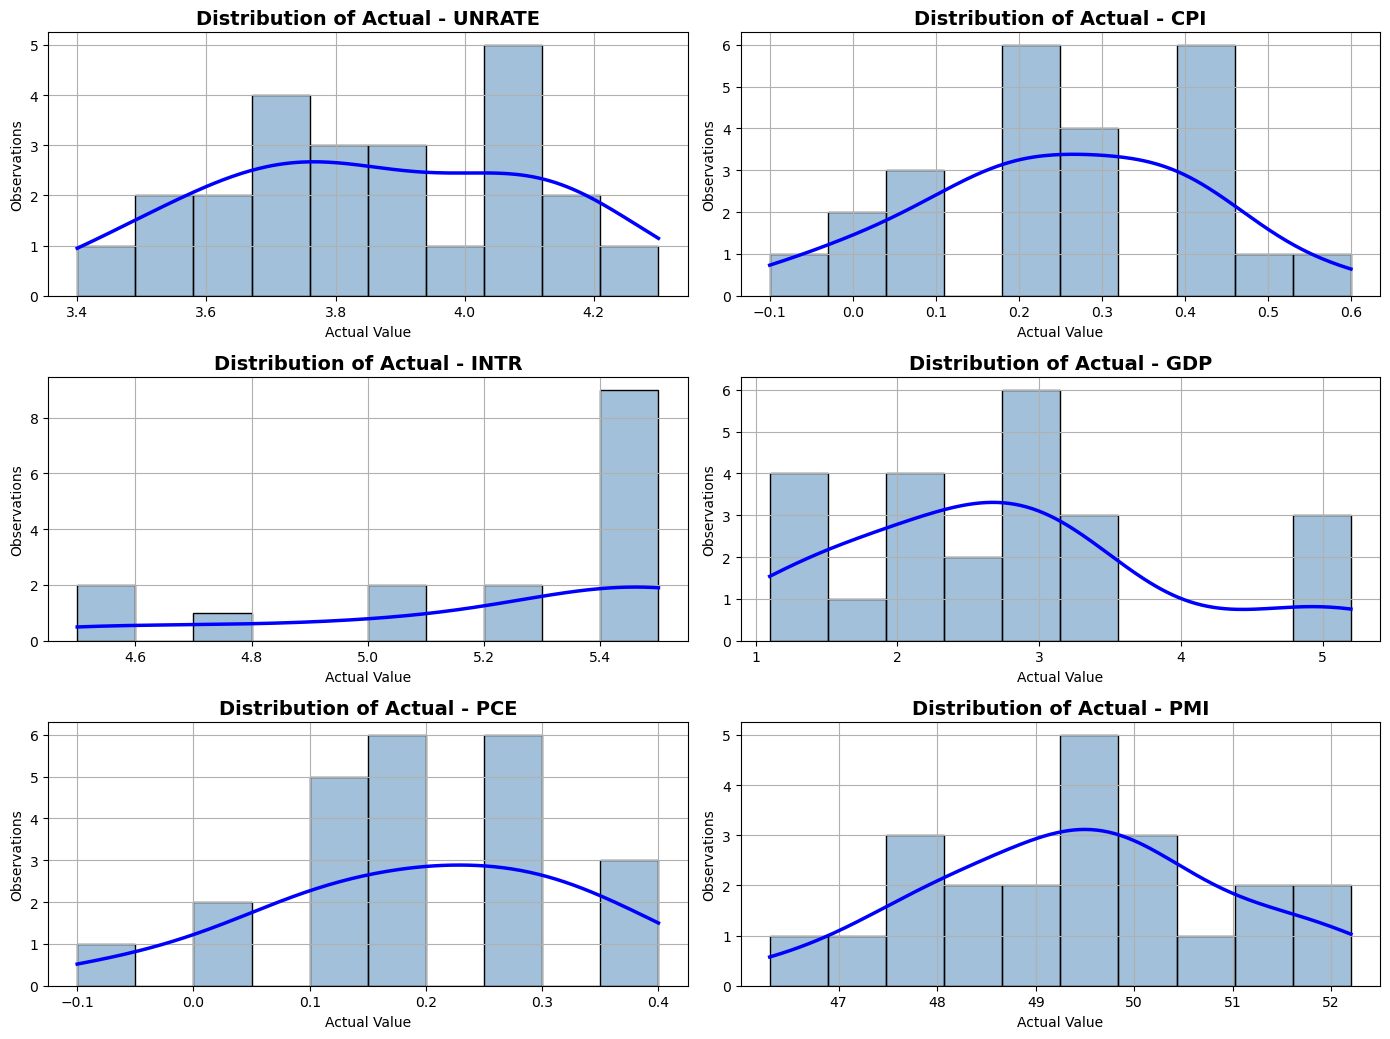

In [10]:
# Distribution plotting of Macro Events
plot_actual_distributions(filtered_macro_df)

----------------------

# <span style="color:blue">Create final df with all Pairs and Macro events</span>
1. Fetch all data for the past 2 years for each pair 'fetch_and_combine_fx_data(macro_df, pair)'
2. Merge the datasets 
3. Fetch only data with events (-5 +10 from the event)

In [11]:
# Save them to save time next time you run them
# eur = fetch_and_combine_fx_data(filtered_macro_df, "USDEUR")
# gbp = fetch_and_combine_fx_data(filtered_macro_df, "USDGBP")
# cnh = fetch_and_combine_fx_data(filtered_macro_df, "USDCNH")

# Load CSVs
eur = pd.read_csv("data/USDEUR_data.csv")
gbp = pd.read_csv("data/USDGBP_data.csv")
cnh = pd.read_csv("data/USDCNH_data.csv")

for df in [eur, gbp, cnh]:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=True)
    df['Datetime'] = df['Datetime'].dt.strftime("%d/%m/%Y %H:%M")
    df.set_index('Datetime', inplace=True)
    
# Merge all three dataframes on 'Datetime' index, keeping only matching timestamps
merged_df = eur.merge(gbp, left_index=True, right_index=True, how="inner") \
               .merge(cnh, left_index=True, right_index=True, how="inner")

# Ensure the index is in datetime format
merged_df.index = pd.to_datetime(merged_df.index, format="%d/%m/%Y %H:%M")

# Sort the merged DataFrame by 'Datetime' index
merged_df.sort_index(inplace=True)

# Merged DataFrame before the filtering out all datetimes except for the most volatile time around the event
merged_df

,USDEUR_High,USDEUR_Low,USDEUR_AdjClose,USDEUR_Volume,USDEUR_vwap,USDEUR_Volatility,USDEUR_AverageVolatility,USDEUR_VolatilityMultiplier,USDGBP_High,USDGBP_Low,...,USDGBP_AverageVolatility,USDGBP_VolatilityMultiplier,USDCNH_High,USDCNH_Low,USDCNH_AdjClose,USDCNH_Volume,USDCNH_vwap,USDCNH_Volatility,USDCNH_AverageVolatility,USDCNH_VolatilityMultiplier
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-03-10 00:00:00,0.94466,0.9443,0.94459,55,0.9446,NaN,0.000144,NaN,0.83872,0.838490,...,0.000156,NaN,6.97835,6.97635,6.97751,169,6.9776,NaN,0.000106,NaN
2023-03-10 00:01:00,0.94464,0.9444,0.94457,71,0.9446,0.000021,0.000144,0.15,0.83887,0.838620,...,0.000156,1.15,6.97814,6.97672,6.97749,109,6.9775,0.000003,0.000106,0.03
2023-03-10 00:02:00,0.94461,0.9444,0.94448,84,0.9445,0.000095,0.000144,0.66,0.83890,0.838560,...,0.000156,0.38,6.97801,6.97646,6.97784,121,6.9775,0.000050,0.000106,0.48
2023-03-10 00:03:00,0.94452,0.9443,0.94430,67,0.9445,0.000191,0.000144,1.33,0.83881,0.838590,...,0.000156,0.54,6.97786,6.97586,6.97711,103,6.9770,0.000105,0.000106,0.99
2023-03-10 00:04:00,0.94439,0.9441,0.94427,60,0.9443,0.000032,0.000144,0.22,0.83870,0.838480,...,0.000156,0.54,6.97776,6.97593,6.97659,86,6.9768,0.000074,0.000106,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-12 23:55:00,0.96238,0.9621,0.96220,32,0.9623,0.000187,0.000109,1.71,0.80330,0.803110,...,0.000112,0.78,7.31005,7.30872,7.30991,12,7.3097,0.000008,0.000050,0.16
2025-02-12 23:56:00,0.96231,0.9620,0.96220,30,0.9623,0.000000,0.000109,0.00,0.80318,0.803148,...,0.000112,0.00,7.31003,7.30874,7.30987,14,7.3098,0.000005,0.000050,0.11
2025-02-12 23:57:00,0.96231,0.9621,0.96220,41,0.9623,0.000000,0.000109,0.00,0.80319,0.803140,...,0.000112,0.00,7.30982,7.30860,7.30974,13,7.3095,0.000018,0.000050,0.35


-----------

#  <span style="color:blue"> Final DataFrame </span>

In [12]:
# FX data extracted
fx_data = extract_relevant_fx_data(merged_df, macro_df, 5, 10)

# Final dataframe after event time analysis
final_data = fill_in_missing_minute(fx_data)

# Compute log returns for each FX pair
for pair in ['USDEUR', 'USDGBP', 'USDCNH']:
    price_col = f"{pair}_AdjClose"
    final_data[f"{pair}_log_return"] = np.log(final_data[price_col]) - np.log(final_data[price_col].shift(1))

final_data

,USDEUR_High,USDEUR_Low,USDEUR_AdjClose,USDEUR_Volume,USDEUR_vwap,USDEUR_Volatility,USDEUR_AverageVolatility,USDEUR_VolatilityMultiplier,USDGBP_High,USDGBP_Low,...,USDCNH_AverageVolatility,USDCNH_VolatilityMultiplier,Ticker,Expected,Actual,Prior,Surprise,USDEUR_log_return,USDGBP_log_return,USDCNH_log_return
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-03-10 13:25:00,0.94447,0.943841,0.94436,149,0.9442,0.000169,0.000144,1.18,0.83399,0.83356,...,0.000106,1.73,UNRATE,3.4,3.6,3.4,0.2,NaN,NaN,NaN
2023-03-10 13:26:00,0.94442,0.944000,0.94417,117,0.9443,0.000201,0.000144,1.40,0.83392,0.83360,...,0.000106,1.28,UNRATE,3.4,3.6,3.4,0.2,-0.000201,-0.000132,-0.000135
2023-03-10 13:27:00,0.94425,0.943800,0.94425,115,0.9441,0.000085,0.000144,0.59,0.83398,0.83357,...,0.000106,0.42,UNRATE,3.4,3.6,3.4,0.2,0.000085,0.000099,-0.000045
2023-03-10 13:28:00,0.94431,0.943931,0.94428,165,0.9442,0.000032,0.000144,0.22,0.83420,0.83370,...,0.000106,2.90,UNRATE,3.4,3.6,3.4,0.2,0.000032,0.000273,-0.000306
2023-03-10 13:29:00,0.94429,0.943900,0.94410,197,0.9441,0.000191,0.000144,1.33,0.83413,0.83283,...,0.000106,0.22,UNRATE,3.4,3.6,3.4,0.2,-0.000191,-0.000456,-0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-12 13:36:00,0.96915,0.968220,0.96859,192,0.9687,0.000341,0.000109,3.12,0.80751,0.80701,...,0.000050,3.67,CPI,0.3,0.5,0.4,0.2,-0.000341,-0.000099,-0.000184
2025-02-12 13:37:00,0.96893,0.968300,0.96872,176,0.9687,0.000134,0.000109,1.23,0.80760,0.80723,...,0.000050,1.69,CPI,0.3,0.5,0.4,0.2,0.000134,0.000198,0.000085
2025-02-12 13:38:00,0.96873,0.968060,0.96828,195,0.9683,0.000454,0.000109,4.16,0.80757,0.80696,...,0.000050,3.21,CPI,0.3,0.5,0.4,0.2,-0.000454,-0.000347,-0.000161


-----------

# <span style="color:blue"> Most Volatile timeframe on Event </span>


Total events analyzed: 130
Average Time Difference: -5 min (start) | 10 min (end)


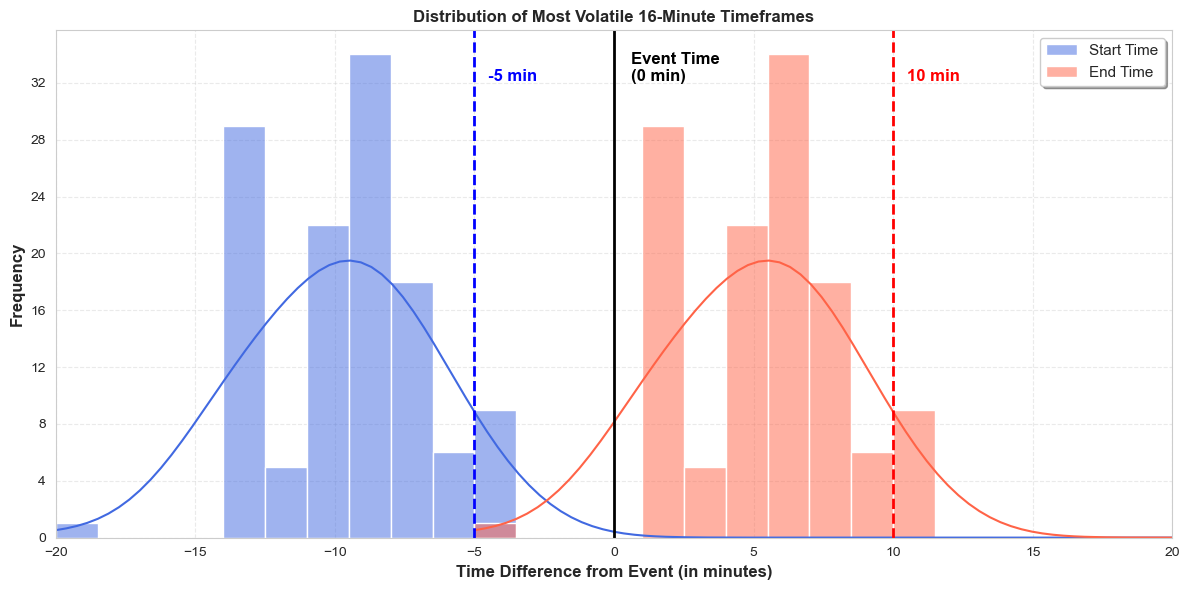

In [13]:
# Run the function
most_volatile_times, avg_start, avg_end, time_differences = find_most_volatile_16min(final_data, filtered_macro_df)

# Plot of most volatile timeframe
plot_time_differences(time_differences, avg_start, avg_end)

------------

#  <span style="color:blue"> Macro Event Importance Analysis </span>

1. Do some feature importance to keep the major macro data releases and do detailed analysis on these ones.
2. Explain that based on discussion with Risk Manager... from case studies these are athe most importants and refer to other papers too.

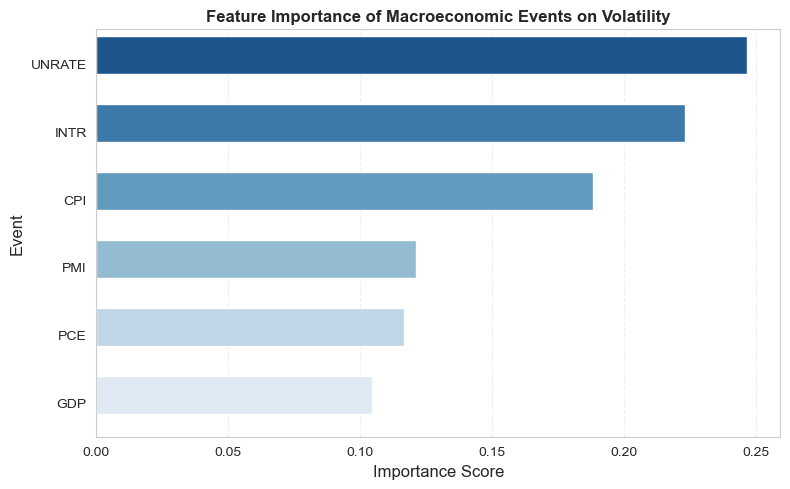

In [14]:
# Compute Event Importance based on Volatility
importance_results = compute_event_importance(final_data)

# Plot the events with their importance
plot_event_importance(importance_results)

------------

# <span style="color:blue"> Prior vs Now (volatility importance)</span>

1. What is the volatility of the events over the past 3 years? This correlates with the one above (the one above is a combination of all 3 years)

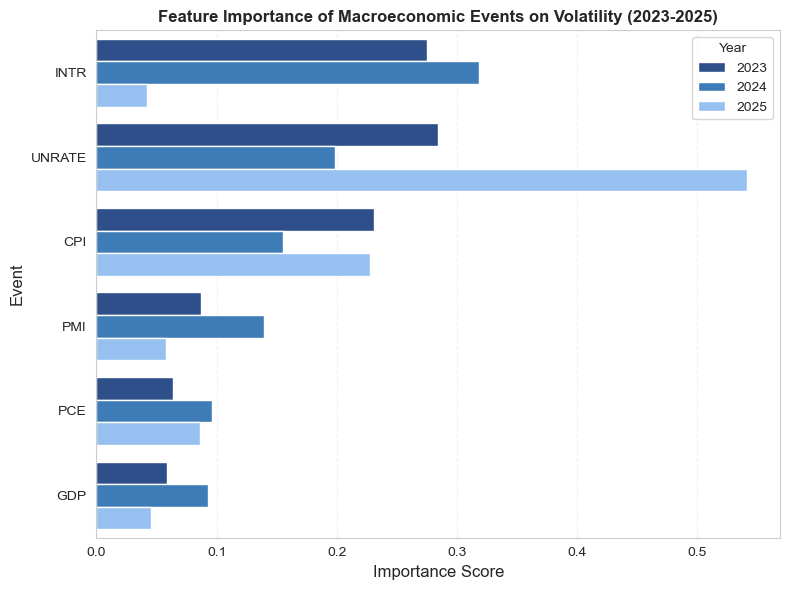

In [15]:
# Macro Data Event importance by year (2023-2025)
importance_results = compute_event_importance_by_year(final_data, years=[2023, 2024, 2025])

# Plot the results
plot_event_importance_by_year(importance_results)

# <span style="color:blue"> Volatility summary </span>

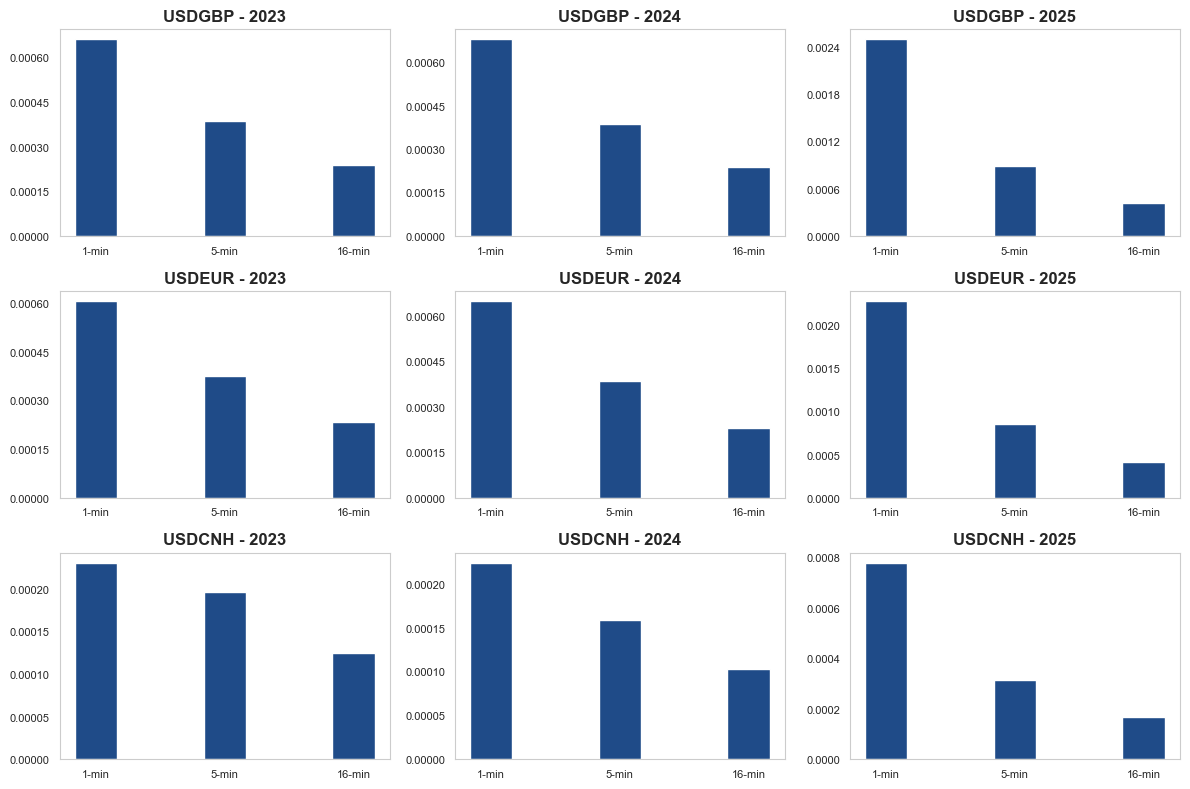

In [16]:
# Short Term Volatility of Pairs per Year
plot_short_term_vol_per_year(final_data)

# <span style="color:blue"> Expectations vs Actual </span>

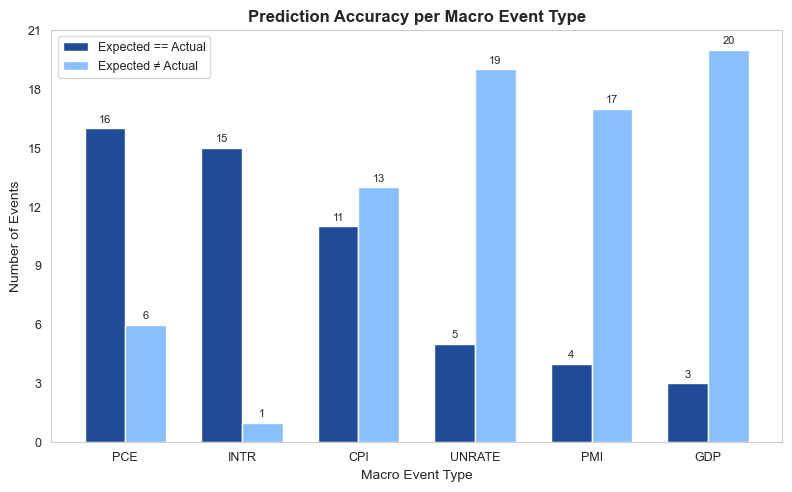

In [17]:
# Plot number of grouped events where analysts predicted the macro data accurately
plot_expectations_vs_actual(final_data)

# </span> <span style="color:blue">Volatility Increase on each event table - Data Release Trend: Before/On/After

1. Charts
2. Need to find Var (and expected JUMP)
    * Shall I set Var such as +- |abs_return| ?
    * Shall I set Var such as min | max ?

In [28]:
# Run the analysis and get individual DataFrames
fx_analysis_results = analyze_event_windows(final_data)

usdeur_df = fx_analysis_results['USDEUR_AdjClose']
usdgbp_df = fx_analysis_results['USDGBP_AdjClose']
usdcnh_df = fx_analysis_results['USDCNH_AdjClose']

data = [usdgbp_df, usdeur_df, usdcnh_df]
titles = ['USDGBP', 'USDEUR', 'USDCNH']

for i in range(len(data)):
    print(f"*** {titles[i]} ***")
    display(data[i])
    print("\n")

*** USDGBP ***


,Event_Type,Time_Window,Minimum_Return,Maximum_Return,Average_Absolute_Return,Average_Volatility
0,CPI,Before,-0.000701,0.000867,0.000129,0.000130
1,CPI,On,-0.005445,0.004543,0.001155,0.000609
2,CPI,After,-0.001544,0.001681,0.000283,0.000456
3,GDP,Before,-0.000458,0.000305,0.000101,0.000083
4,GDP,On,-0.000497,0.000834,0.000236,0.000181
5,GDP,After,-0.000942,0.000953,0.000178,0.000223
6,INTR,Before,-0.003956,0.003972,0.000294,0.000238
7,INTR,On,-0.004329,0.004096,0.001479,0.000890
8,INTR,After,-0.002850,0.003109,0.000311,0.000592
9,PCE,Before,-0.000468,0.000404,0.000109,0.000101




*** USDEUR ***


,Event_Type,Time_Window,Minimum_Return,Maximum_Return,Average_Absolute_Return,Average_Volatility
0,CPI,Before,-0.000453,0.000904,0.000115,0.000117
1,CPI,On,-0.004420,0.004295,0.001048,0.000551
2,CPI,After,-0.001313,0.001798,0.000274,0.000433
3,GDP,Before,-0.000646,0.000396,0.000128,0.000117
4,GDP,On,-0.000738,0.001438,0.000275,0.000224
5,GDP,After,-0.000838,0.000914,0.000184,0.000239
6,INTR,Before,-0.003880,0.003884,0.000281,0.000239
7,INTR,On,-0.003762,0.002979,0.001404,0.000852
8,INTR,After,-0.001268,0.001741,0.000281,0.000517
9,PCE,Before,-0.000454,0.000321,0.000094,0.000092




*** USDCNH ***


,Event_Type,Time_Window,Minimum_Return,Maximum_Return,Average_Absolute_Return,Average_Volatility
0,CPI,Before,-0.000322,0.000273,0.000064,0.000059
1,CPI,On,-0.001735,0.001061,0.000401,0.000223
2,CPI,After,-0.001199,0.001571,0.000155,0.000219
3,GDP,Before,-0.000241,0.000255,0.000059,0.000047
4,GDP,On,-0.000250,0.000395,0.000127,0.000103
5,GDP,After,-0.000435,0.000478,0.000092,0.000114
6,INTR,Before,-0.000996,0.000403,0.000097,0.000078
7,INTR,On,-0.001308,0.000872,0.000340,0.000235
8,INTR,After,-0.000982,0.001197,0.000137,0.000205
9,PCE,Before,-0.000267,0.000280,0.000057,0.000051


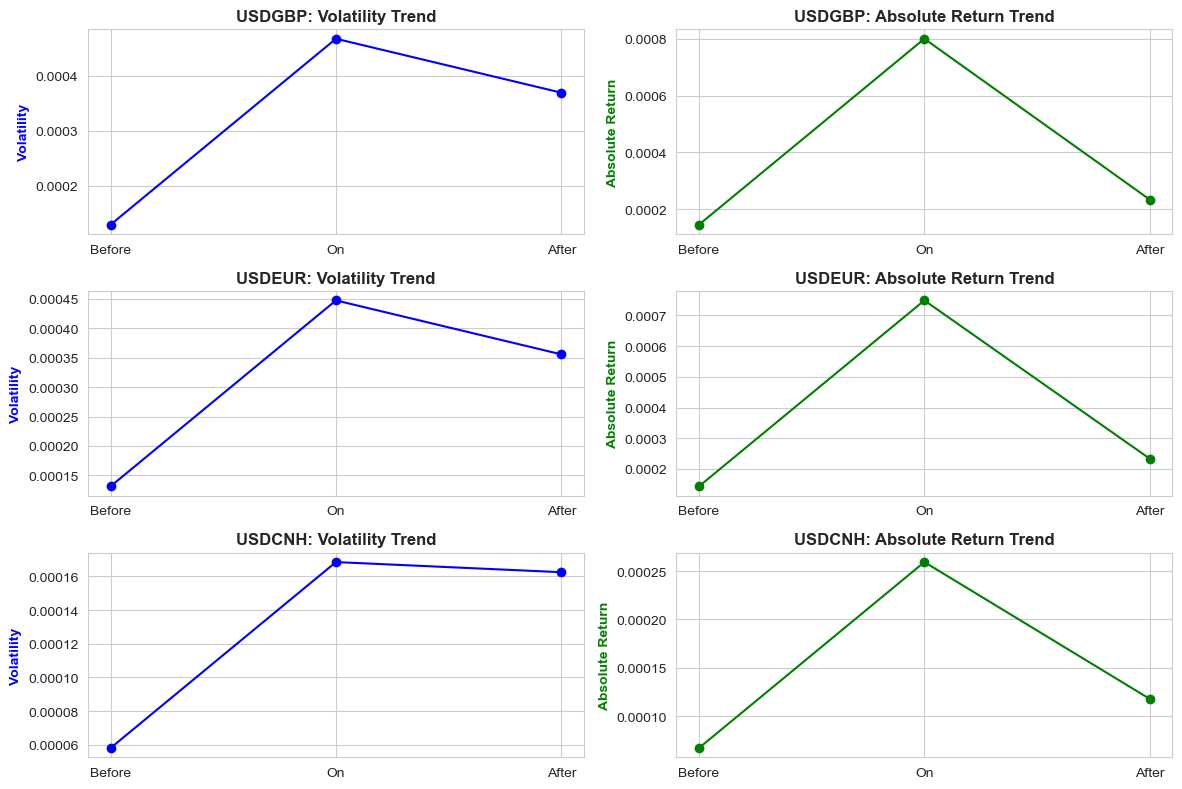

In [29]:
# Call the function for all three pairs
plot_fx_event_patterns(fx_analysis_results, ['USDGBP_AdjClose', 'USDEUR_AdjClose', 'USDCNH_AdjClose'])

# </span> <span style="color:blue"> Macro Event Volatility Summary

In [34]:
# Create formatted summary
format_macro_summary_table(fx_analysis_results)

,EVENT,COUNTRY,COEFF,ROB.T,%JUMP,%DAY,PAIR
0,CPI,US,0.00055,4.71,370.68,100.14,USDEUR
1,GDP,US,0.00022,1.92,91.89,62.98,USDEUR
2,INTR,US,0.00085,3.57,256.92,112.70,USDEUR
3,PCE,US,0.00023,2.53,152.88,69.80,USDEUR
4,PMI,US,0.00018,1.63,63.40,57.58,USDEUR
5,UNRATE,US,0.00065,5.59,459.38,104.40,USDEUR
6,CPI,US,0.00061,4.70,369.77,103.97,USDGBP
7,GDP,US,0.00018,2.20,119.82,59.30,USDGBP
8,INTR,US,0.00089,3.73,273.40,107.15,USDGBP
9,PCE,US,0.00024,2.37,137.42,69.82,USDGBP


# <span style="color:blue"> Correlation of USD pairs</span>

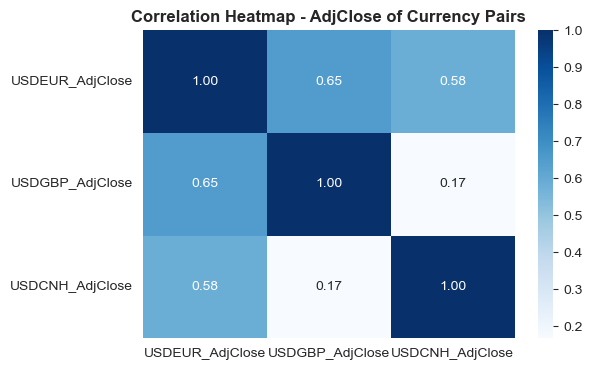

In [35]:
# Run the function
analyze_usd_pairs_correlation(final_data, macro_df)

# <span style="color:blue"> Yearly Volume per USD Pair</span>

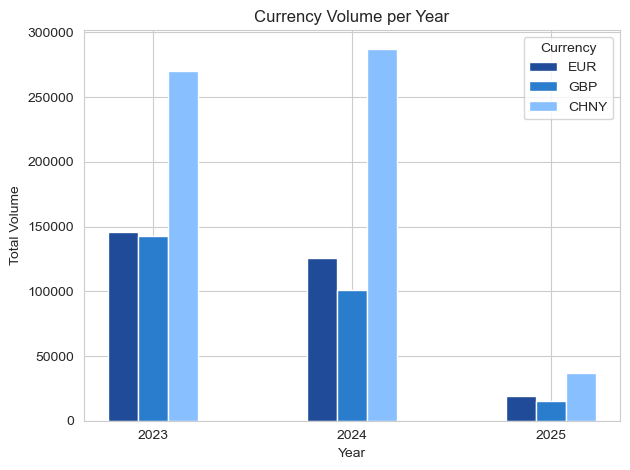

In [36]:
plot_currency_volume_per_year(final_data)

# <span style="color:green"> Prediction
### <span style="color:green">For the variance/bounds:
1. <span style="color:green"> GARCH</span>
2. <span style="color:green"> Quantiles (5% and 95%)</span>
3. <span style="color:green"> MC</span>

### <span style="color:green">For the return prediction
1. <span style="color:green">AI</span>

### <span style="color:green"> TODO </span>
* <span style="color:green"> Group all data to find the bounds per:
    * Event
    * Minute On and After</span>

### <span style="color:green"> Return DF where each row: </span>
1. <span style="color:green"> Datetime </span>
2. <span style="color:green"> Price </span>
3. <span style="color:green">Cumulative Return in %
4. <span style="color:green"> Volatility Bounds / Variance in % (tuple e.g., (-0.05, 0.55)) </span>
5. <span style="color:green"> Event </span>
6. <span style="color:green"> Actual </span>
7. <span style="color:green"> Expected </span>
8. <span style="color:green"> Surprise </span>


### Last
* KPIS / Testing:
    * ML: MSE and other metrics
    * <span style="color:green"> Bounds: Matrix how many of the past events was within the boundaries given that the data was not known.
    * Matrix:
        - For LSTM and for GARCH (2 tables for each)
            - 1st minute of event predicted correct or not (above or below the -1t based on actual)
            - 11th minute (last) of event was the trend correct or not (above or below the -1t based on actual)
* <span style="color:green"> Plot nicely a chart
    * <span style="color:green"> Actual line
    * <span style="color:green"> Prediction line (GARCH and LSTM)
    * <span style="color:green"> Variance lines

### MC percentiles(5,95)

In [37]:
def predict_mc_bounds(fx_pair: str, event_time: str, event_ticker: str, expected: float, actual: float, base_price: float):
    """
    Computes a widened Monte Carlo price bound for the first minute after a macro event.

    Params:
        fx_pair (str): Currency pair (e.g., 'USDEUR').
        event_time (str): Timestamp of the event (string format).
        event_ticker (str): Event identifier (e.g., 'CPI').
        expected (float): Expected value of the macro event.
        actual (float): Actual released value of the macro event.
        base_price (float): Last known FX price before the event.

    Returns:
        output_df (DataFrame): DataFrame with 11 bounds: Tuple of (lower_price, upper_price) for minute 0, else (None, None).
    """

    event_time = pd.to_datetime(event_time, dayfirst=True)
    surprise = actual - expected

    # Prepare data
    df_event = final_data[final_data['Ticker'] == event_ticker].copy()
    df_event['Datetime'] = df_event.index
    df_event['EventGroupID'] = (df_event['Datetime'].diff() > pd.Timedelta(minutes=1)).cumsum()

    # Extract event windows
    all_event_windows = []
    for _, group in df_event.groupby('EventGroupID'):
        group = group.reset_index(drop=True)
        if len(group) >= 16:
            try:
                window = group.loc[5:15].copy()
                window['MinuteOffset'] = range(0, len(window))
                window['Surprise'] = group['Surprise'].iloc[0]
                all_event_windows.append(window)
            except:
                continue

    if not all_event_windows:
        return pd.DataFrame(columns=["Datetime", "Bounds", "Ticker", "Expected", "Actual", "Surprise"])

    # Concatinate all event windows
    event_windows_df = pd.concat(all_event_windows)
    # Filter event windows that match the same event_ticker
    same_ticker = event_windows_df[event_windows_df['Ticker'] == event_ticker]
    # Use all minute-0 returns for this ticker
    returns = same_ticker[same_ticker['MinuteOffset'] == 0][f"{fx_pair}_log_return"].dropna()

    # Get base price if not provided
    if base_price is None:
        price_col = f"{fx_pair}_AdjClose"
        base_price = float(df_event[price_col].iloc[-1])

    simulated = np.random.choice(returns, size=100000, replace=True)
    lower, upper = np.percentile(simulated, [5, 95])

    # Convert to prices
    lower_price = round(base_price * np.exp(lower), 5)
    upper_price = round(base_price * np.exp(upper), 5)
    bounds = (lower_price, upper_price)

    # Build result (only minute 0 and rest as NaNs)
    result = []
    for i in range(11):  # 0 to +10 minutes
        dt = event_time + pd.Timedelta(minutes=i)
        result.append((dt, bounds if i == 0 else (None, None)))

    output_df = pd.DataFrame(result, columns=["Datetime", "Bounds"])
    output_df["Event"] = event_ticker
    output_df["Expected"] = expected
    output_df["Actual"] = actual
    output_df["Surprise"] = surprise

    return output_df

### Bounds validation results on all events

In [38]:
def check_mc_bounds_on_all_events(final_data):
    """
    Processes FX event data to extract open prices, compute Monte Carlo prediction bounds,
    and evaluate whether actual prices fall within, above, or below those bounds.

    Parameters:
        final_data (pd.DataFrame): A DataFrame with Datetime index and columns including
                                   *_AdjClose, Ticker, Expected, and Actual.

    Returns:
        Tuple:
            - pd.DataFrame: Event rows with *_open_price and *_bounds columns added.
            - pd.DataFrame: Summary table of bound evaluation for each FX pair.
    """
    
    # Step 1: Prepare base data
    df = final_data.reset_index()[[
        "Datetime", "USDEUR_AdjClose", "USDGBP_AdjClose", "USDCNH_AdjClose", "Ticker", "Expected", "Actual"
    ]].copy()

    df['Datetime'] = final_data.index
    df['Date'] = df['Datetime'].dt.date
    df = df.sort_values('Datetime')

    # Step 2: Get 5th (open price) and 6th (event reaction) rows per (Date, Ticker)
    open_rows = df.groupby(['Date', 'Ticker'], group_keys=False).apply(lambda x: x.iloc[4:5]).reset_index(drop=True)
    event_rows = df.groupby(['Date', 'Ticker'], group_keys=False).apply(lambda x: x.iloc[5:6]).reset_index(drop=True)

    # Step 3: Copy open prices into event rows
    for col in ["USDEUR", "USDGBP", "USDCNH"]:
        event_rows[f"{col}_open_price"] = open_rows[f"{col}_AdjClose"].values

    # Step 4: Predict bounds
    def get_bounds(row, fx):
        try:
            df_bounds = predict_mc_bounds(
                fx_pair=fx,
                event_time=row['Datetime'],
                event_ticker=row['Ticker'],
                expected=row['Expected'],
                actual=row['Actual'],
                base_price=row[f"{fx}_open_price"]
            )
            return df_bounds.iloc[0]['Bounds']
        except:
            return (None, None)

    for fx in ["USDEUR", "USDGBP", "USDCNH"]:
        event_rows[f"{fx}_bounds"] = event_rows.apply(lambda row: get_bounds(row, fx), axis=1)

    # Step 5: Evaluate results
    summary = {}
    for fx in ["USDEUR", "USDGBP", "USDCNH"]:
        actual = event_rows[f"{fx}_AdjClose"]
        bounds = event_rows[f"{fx}_bounds"]
        within = above = below = 0

        for price, bound in zip(actual, bounds):
            if bound is None or bound[0] is None:
                continue
            low, high = bound
            if low <= price <= high:
                within += 1
            elif price > high:
                above += 1
            elif price < low:
                below += 1

        summary[fx] = {
            "Within_Bounds": within,
            "Above_Bounds": above,
            "Below_Bounds": below,
            "Total_Evaluated": within + above + below
        }
    
    summary = pd.DataFrame(summary).T
    
    summary["Within bounds %"] = round(summary["Within_Bounds"] / summary["Total_Evaluated"], 2) 
    
    event_rows = event_rows[["USDEUR_AdjClose", "USDGBP_AdjClose", "USDCNH_AdjClose", "Ticker", "Expected", "Actual",
                            "USDEUR_bounds", "USDGBP_bounds", "USDCNH_bounds"]]
    
    return event_rows, summary

-------

### Garch(1,1)

In [39]:
def predict_garch_reaction_by_ticker(fx_pair: str, event_time: str, event_ticker: str,
                                     expected: float, actual: float, df: pd.DataFrame) -> pd.DataFrame:
    """
    Predicts FX returns using GARCH(1,1) for a given macro event, adjusting for surprise direction.
    Boosts first minute return using empirical behavior across similar events.

    Parameters:
    - fx_pair: e.g., 'USDEUR'
    - event_time: string like "10/03/2025 13:30"
    - event_ticker: macro event, e.g., 'CPI'
    - expected: expected macro value
    - actual: actual macro value
    - df: DataFrame with 'Ticker', 'Actual', 'Expected' and FX return columns like 'USDEUR_log_return'

    Returns:
    - DataFrame with predicted returns and volatility from t=0 to t=10
    """
    event_time = pd.to_datetime(event_time, dayfirst=True)
    log_return_col = f"{fx_pair}_log_return"
    surprise = actual - expected

    # Filter data by ticker
    df_ticker = df[df['Ticker'] == event_ticker].copy()
    df_ticker['Surprise'] = df_ticker['Actual'] - df_ticker['Expected']

    # Collect pre-event returns (first 5 mins of each event day)
    pre_event_returns = []
    minute_0_returns = []

    for idx in df_ticker.index:
        event_day = idx.floor('D')
        day_data = df.loc[(df.index >= event_day) & (df.index < event_day + timedelta(days=1))]

        # First 5 mins (pre-event)
        returns = day_data[log_return_col].dropna().iloc[:5]
        if len(returns) == 5:
            pre_event_returns.append(returns)

        # Event minute return (6th row = index 5)
        if log_return_col in day_data.columns and len(day_data[log_return_col].dropna()) > 5:
            r = day_data[log_return_col].dropna().iloc[5]
            if not np.isnan(r):
                minute_0_returns.append(r)

    # Fit GARCH(1,1)
    all_returns = pd.concat(pre_event_returns)
    model = arch_model(all_returns, vol='Garch', p=1, q=1)
    res = model.fit(disp="off")

    # Estimate average boost at event minute
    avg_event_return_boost = np.mean(np.abs(minute_0_returns)) if minute_0_returns else 0

    # Simulate returns
    simulated_returns = []
    sigma2 = res.conditional_volatility[-1]**2
    last_resid = res.resid[-1]
    omega = res.params['omega']
    alpha = res.params['alpha[1]']
    beta = res.params['beta[1]']
    mu = res.params['mu']

    np.random.seed(42)
    for i in range(11):
        sigma2 = omega + alpha * last_resid**2 + beta * sigma2
        std = np.sqrt(sigma2)
        shock = np.random.normal(0, std)
        predicted_return = mu + shock

        # First minute
        if i == 0:
            predicted_return += np.sign(surprise) * avg_event_return_boost

        simulated_returns.append((predicted_return, std))
        last_resid = shock

    # Format output
    result_df = pd.DataFrame(simulated_returns, columns=['Predicted_Mean_Return', 'Predicted_StdDev'])
    result_df['Datetime'] = [event_time + timedelta(minutes=i) for i in range(11)]
    result_df['FX_Pair'] = fx_pair
    result_df['Expected'] = expected
    result_df['Actual'] = actual
    result_df['Surprise'] = surprise
    result_df['Ticker'] = event_ticker

    return result_df[['Datetime', 'FX_Pair', 'Predicted_Mean_Return', 'Predicted_StdDev', 
                      'Expected', 'Actual', 'Surprise', 'Ticker']]

# Run the function
predict_garch_reaction_by_ticker("USDGBP", "10/03/2025 13:30", "CPI", 0.4, 0.5, final_data)

C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,Datetime,FX_Pair,Predicted_Mean_Return,Predicted_StdDev,Expected,Actual,Surprise,Ticker
0,2025-03-10 13:30:00,USDGBP,0.001493,0.001409,0.4,0.5,0.1,CPI
1,2025-03-10 13:31:00,USDGBP,-0.000558,0.001422,0.4,0.5,0.1,CPI
2,2025-03-10 13:32:00,USDGBP,0.000556,0.001417,0.4,0.5,0.1,CPI
3,2025-03-10 13:33:00,USDGBP,0.001833,0.001441,0.4,0.5,0.1,CPI
4,2025-03-10 13:34:00,USDGBP,-0.000734,0.001592,0.4,0.5,0.1,CPI
5,2025-03-10 13:35:00,USDGBP,-0.000729,0.001571,0.4,0.5,0.1,CPI
6,2025-03-10 13:36:00,USDGBP,0.002091,0.001553,0.4,0.5,0.1,CPI
7,2025-03-10 13:37:00,USDGBP,0.000956,0.001717,0.4,0.5,0.1,CPI
8,2025-03-10 13:38:00,USDGBP,-0.001174,0.001730,0.4,0.5,0.1,CPI
9,2025-03-10 13:39:00,USDGBP,0.000566,0.001710,0.4,0.5,0.1,CPI


--------

### LSTM structure

In [141]:
def train_lstm_for_pair(final_data, pair_fx, sequence_length=5, forecast_horizon=11, epochs=350, batch_size=32):
    """
    Trains an LSTM model to forecast FX prices for macro events, with custom attenuation for low-movement event types.

    Params:
        final_data (DataFrame): Full historical FX and event dataset.
        pair_fx (str): Currency pair prefix (e.g., 'USDEUR').
        sequence_length (int): Number of past steps used as input.
        forecast_horizon (int): Number of future steps to predict.
        epochs (int): Training epochs.
        batch_size (int): Batch size for training.

    Returns:
        model: Trained Keras LSTM model.
        demo_preds (list): Predicted sequences for demo events.
        demo_actuals (list): Actual sequences for demo events.
        demo_inputs (list): Input sequences used for demo prediction.
        price_scaler (MinMaxScaler): Scaler for inverse-transforming prices.
        scaler (MinMaxScaler): Scaler for full input features.
        features (list): List of feature names used in training.
        pair_fx (str): Currency pair name.
        df (DataFrame): Preprocessed DataFrame with features.
        demo_events (list): List of demo event types used.
    """

    df = final_data.copy().reset_index()
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # 1. Select features
    features = [
        f'{pair_fx}_AdjClose',
        f'{pair_fx}_Volume',
        f'{pair_fx}_vwap',
        f'{pair_fx}_Volatility',
        f'{pair_fx}_AverageVolatility',
        'Ticker', 'Expected', 'Actual', 'Surprise'
    ]
    df = df[['Datetime'] + features]

    # 2. Encode Ticker
    df['Ticker'] = df['Ticker'].astype('category')
    ticker_categories = df['Ticker'].cat.categories
    df['Ticker'] = df['Ticker'].cat.codes
    event_to_code = dict(zip(ticker_categories, range(len(ticker_categories))))

    # 3. Scale
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features])
    scaled_df = pd.DataFrame(scaled_data, columns=features)
    scaled_df['Ticker'] = df['Ticker'].values  # preserve encoded tickers

    price_scaler = MinMaxScaler()
    price_scaler.fit(df[[f'{pair_fx}_AdjClose']])

    # 4. Create sequences per event
    X_train, y_train, X_val, y_val = [], [], [], []
    val_event_set = set()

    for event_code in scaled_df['Ticker'].unique():
        event_df = scaled_df[scaled_df['Ticker'] == event_code].reset_index(drop=True)
        data = event_df[features].values

        for i in range(len(data) - (sequence_length + forecast_horizon)):
            seq_x = data[i:i + sequence_length]
            seq_y = data[i + sequence_length:i + sequence_length + forecast_horizon, 0]  # AdjClose

            if event_code not in val_event_set:
                X_val.append(seq_x)
                y_val.append(seq_y)
                val_event_set.add(event_code)
            else:
                X_train.append(seq_x)
                y_train.append(seq_y)

    # Convert to np arrays
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)

    # 5. Build model
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
        LSTM(64),
        Dense(forecast_horizon)
    ])
    model.compile(optimizer='adam', loss='mse')

    # 6. Train
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

    # 7. Predict one sample per event
    low_movement_events = {'PMI', 'PCE', 'GDP'}
    attenuation_factor_non_chinese = 0.08
    attenuation_factor_chinese = 0.05

    event_types = ['CPI', 'GDP', 'INTR', 'PCE', 'PMI', 'UNRATE']
    demo_inputs, demo_preds, demo_actuals, demo_events = [], [], [], []

    for event in event_types:
        encoded_value = event_to_code.get(event)
        if encoded_value is None:
            continue

        matched = np.where(X_val[:, -1, features.index('Ticker')] == encoded_value)[0]
        if len(matched) == 0:
            continue

        idx = matched[0]
        sample_input = X_val[idx].reshape(1, sequence_length, X_val.shape[2])
        sample_pred = model.predict(sample_input, verbose=0)[0]
        sample_actual = y_val[idx]
        
        # last known AdjClose before prediction
        pred_base = sample_input[0, -1, 0]  

        # Apply attenuation for low-movement events
        if event in low_movement_events:
            if 'CNY' in pair_fx.upper() or 'CNH' in pair_fx.upper():
                factor = attenuation_factor_chinese
            else:
                factor = attenuation_factor_non_chinese
            sample_pred = pred_base + factor * (sample_pred - pred_base)

        # Reduce volatility of last timestep (t+10) for INTR and UNRATE
        if event in {'INTR', 'UNRATE'}:
            last_step = sample_pred[-1]
            sample_pred[-1] = pred_base + 0.1 * (last_step - pred_base)

        demo_inputs.append(sample_input)
        demo_preds.append(sample_pred)
        demo_actuals.append(sample_actual)
        demo_events.append(event)

    return model, demo_preds, demo_actuals, demo_inputs, price_scaler, scaler, features, pair_fx, df, demo_events

### LSTM training/validation for all pairs across all events

In [139]:
pair_fx_list = ['USDEUR', 'USDGBP', 'USDCNH']
results = {}

for pair_fx in pair_fx_list:
    model, preds, actuals, inputs, price_scaler, scaler, features, fx_name, df, events = train_lstm_for_pair(final_data, pair_fx)
    
    # Check for missing events on validation sets (needs to contain at least 1 for each event)
    expected_events = {'CPI', 'GDP', 'INTR', 'PCE', 'PMI', 'UNRATE'}
    missing = expected_events - set(events)
    if missing:
        print(f"[******WARNING******] {pair_fx} is missing events: {', '.join(missing)}\n")
    else:
        print(f"[OK] {pair_fx} contains all 6 macro events.\n")

    results[pair_fx] = {
        'model': model,
        'preds': preds,
        'actuals': actuals,
        'inputs': inputs,
        'price_scaler': price_scaler,
        'scaler': scaler,
        'features': features,
        'fx_name': fx_name,
        'df': df,
        'events': events
    }

Epoch 1/3
62/62 [==============================] - 5s 23ms/step - loss: 0.0459 - val_loss: 0.0054
Epoch 2/3
62/62 [==============================] - 1s 11ms/step - loss: 0.0172 - val_loss: 0.0011
Epoch 3/3
62/62 [==============================] - 1s 11ms/step - loss: 0.0164 - val_loss: 8.9588e-04
[OK] USDEUR contains all 6 macro events.
Epoch 1/3
62/62 [==============================] - 5s 23ms/step - loss: 0.0551 - val_loss: 0.0278
Epoch 2/3
62/62 [==============================] - 1s 11ms/step - loss: 0.0135 - val_loss: 0.0101
Epoch 3/3
62/62 [==============================] - 1s 11ms/step - loss: 0.0124 - val_loss: 0.0064
[OK] USDGBP contains all 6 macro events.
Epoch 1/3
62/62 [==============================] - 5s 23ms/step - loss: 0.0758 - val_loss: 0.0402
Epoch 2/3
62/62 [==============================] - 1s 10ms/step - loss: 0.0142 - val_loss: 0.0141
Epoch 3/3
62/62 [==============================] - 1s 10ms/step - loss: 0.0133 - val_loss: 0.0079
[OK] USDCNH contains all 6 macro

-----

### LSTM Price Prediction vs Actual plotting - for 6 random (distinct) events per pair

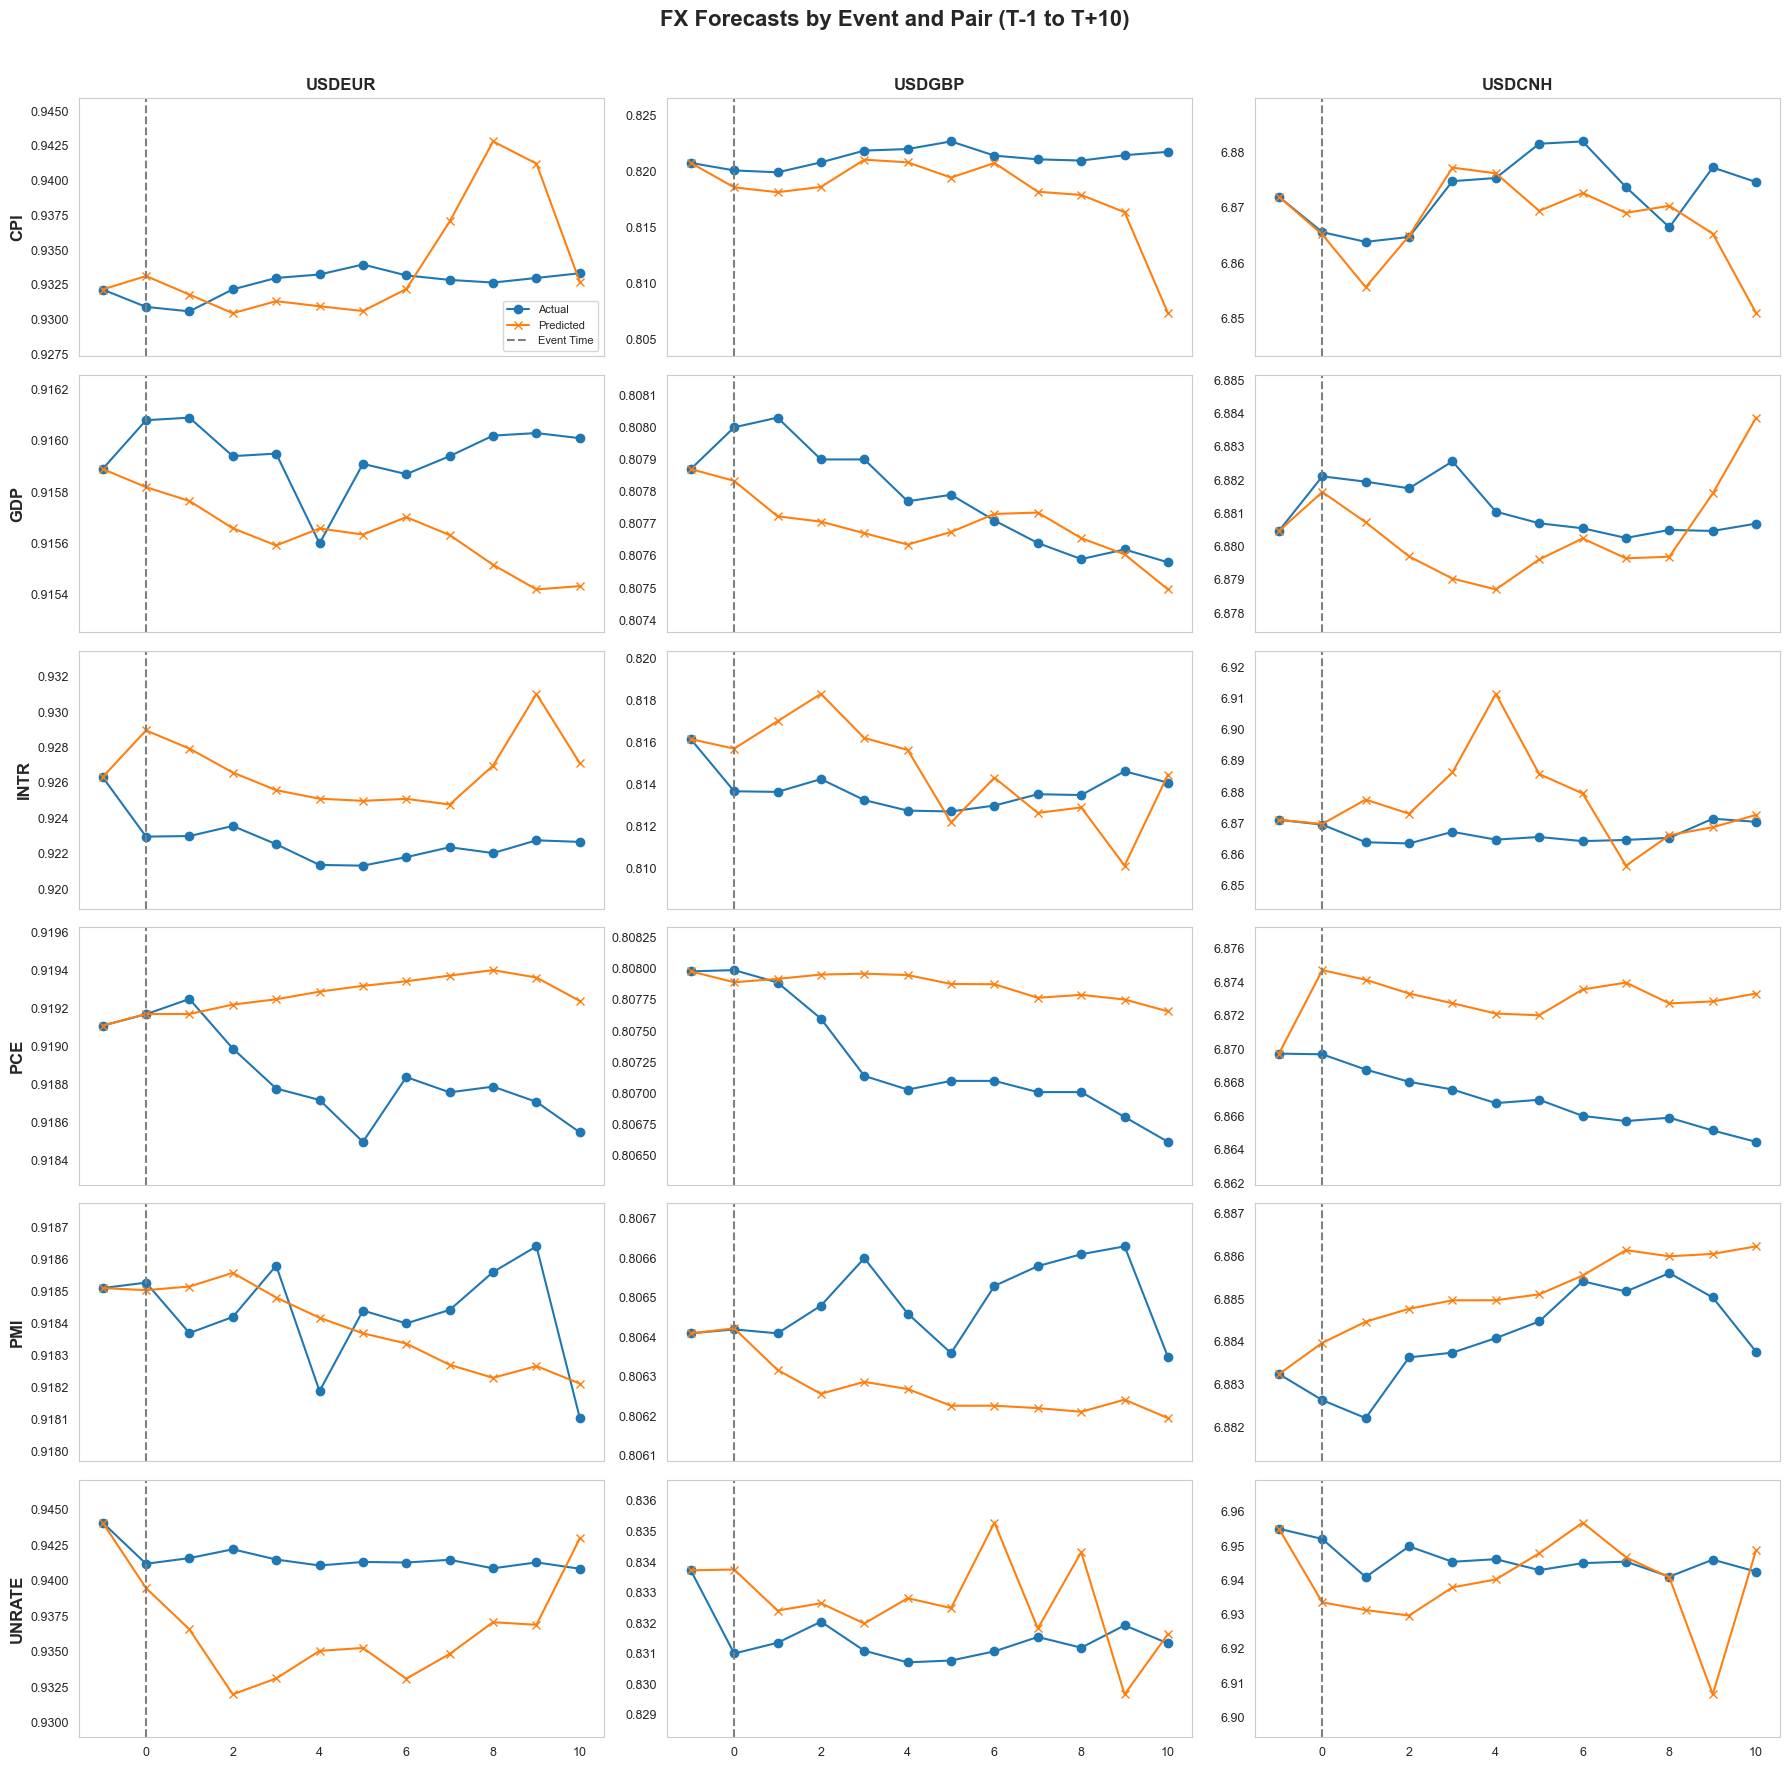

In [46]:
plot_all_events_across_pairs(results) # 350 epochs || weights: PMI/GPD/PCE .08 and chinese .05 and 0.1 for UNRATE/INTR t+10

-----

### Get LSTM price prediction for single event

In [42]:
def forecast_lstm_event_fx(pair_fx, start_datetime_str, raw_input, results_dict):
    """
    Predicts FX prices and returns a DataFrame with forecast horizon.

    Args:
        pair_fx (str): e.g., 'USDEUR'
        start_datetime_str (str): e.g., '10/03/2025 13:30'
        raw_input (np.ndarray): shape (sequence_len, features)
        results_dict (dict): output from LSTM training step

    Returns:
        pd.DataFrame: Forecast results with timestamps
    """
    
    # Get model and scalers
    r = results_dict[pair_fx]
    model, scaler, price_scaler, df = r['model'], r['scaler'], r['price_scaler'], r['df']

    # Encode ticker
    ticker_map = dict(zip(df['Ticker'].astype('category').cat.categories,
                          df['Ticker'].astype('category').cat.codes))
    raw_input = np.array(raw_input, dtype=object)
    raw_input[:, 5] = [ticker_map.get(str(t), 0) for t in raw_input[:, 5]]
    raw_input = raw_input.astype(float)

    # Scale and reshape
    scaled_input = scaler.transform(raw_input)
    scaled_input = scaled_input.reshape(1, *scaled_input.shape)

    # Predict and inverse scale
    pred_scaled = model.predict(scaled_input, verbose=0)
    pred_prices = price_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

    # Generate timestamps from T to T+9
    base_time = datetime.strptime(start_datetime_str, "%d/%m/%Y %H:%M")
    times = [base_time + timedelta(minutes=i) for i in range(len(pred_prices))]

    # Build DataFrame
    result_df = pd.DataFrame({
        "Datetime": times,
        "FX_Pair": pair_fx,
        "LSTM_Price": np.round(pred_prices, 5)
    })

    return result_df

### Combination of Monte Carlo bounds, LSTM price prediction, and Garch price prediction in a final dataframe

In [43]:
def combine_fx_event_predictions(pair_fx: str, start_datetime_str: str, ticker: str, expected: float, actual: float,
                                 final_data: pd.DataFrame, raw_input: np.ndarray, results: dict):
    """
    Combines LSTM, GARCH, and Monte Carlo FX event predictions into a single DataFrame.

    Returns:
        pd.DataFrame with index as datetime and columns:
        ['FX_Pair', 'LSTM_Price', 'GARCH_Price', 'GARCH_StdDev', 'MC_Bounds',
         'Ticker', 'Expected', 'Actual', 'Surprise']
    """
    # Ensure ticker uppercase match
    ticker = ticker.strip().upper()

    # Parse datetime
    start_time = pd.to_datetime(start_datetime_str, dayfirst=True)
    prev_time = start_time - pd.Timedelta(minutes=1)
    surprise = actual - expected
    base_price = float(raw_input[-1, 0])

    # Run models
    lstm_df = forecast_lstm_event_fx(pair_fx, start_datetime_str, raw_input, results)
    garch_df = predict_garch_reaction_by_ticker(pair_fx, start_datetime_str, ticker, expected, actual, final_data)
    mc_df = predict_mc_bounds(pair_fx, start_datetime_str, ticker, expected, actual, base_price)

    # Add cumulative GARCH price
    garch_df['GARCH_Price'] = round(base_price * (1 + garch_df['Predicted_Mean_Return'].cumsum()), 5)
    garch_df['GARCH_StdDev'] = garch_df['Predicted_StdDev']

    # Merge LSTM + GARCH
    df = pd.merge(lstm_df, garch_df[['Datetime', 'GARCH_Price', 'GARCH_StdDev']], on='Datetime', how='inner')

    # Merge MC bounds
    df = pd.merge(df, mc_df[['Datetime', 'Bounds']], on='Datetime', how='left')
    df.rename(columns={'Bounds': 'MC_Bounds'}, inplace=True)

    # Add metadata
    df['FX_Pair'] = pair_fx
    df['Ticker'] = ticker
    df['Expected'] = expected
    df['Actual'] = actual
    df['Surprise'] = surprise

    # Insert pre-event row (-1 minute)
    pre_row = pd.DataFrame([{
        'Datetime': prev_time,
        'FX_Pair': pair_fx,
        'LSTM_Price': base_price,
        'GARCH_Price': base_price,
        'GARCH_StdDev': 0.0,
        'MC_Bounds': (base_price, base_price),
        'Ticker': ticker,
        'Expected': expected,
        'Actual': actual,
        'Surprise': surprise
    }])

    df = pd.concat([pre_row, df], ignore_index=True).sort_values('Datetime')
    df = df.set_index('Datetime')

    return df[['FX_Pair', 'LSTM_Price', 'GARCH_Price', 'GARCH_StdDev', 'MC_Bounds', 'Ticker', 'Expected', 'Actual', 'Surprise']]

### Single Event Testing Final Results

C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,FX_Pair,LSTM_Price,GARCH_Price,GARCH_StdDev,MC_Bounds,Ticker,Expected,Actual,Surprise
Datetime,,,,,,,,,
2023-03-10 13:29:00,USDEUR,0.94410,0.94410,0.000000,"(0.9441, 0.9441)",UNRATE,3.4,3.6,0.2
2023-03-10 13:30:00,USDEUR,0.94781,0.94529,0.001239,"(0.9412, 0.9486)",UNRATE,3.4,3.6,0.2
2023-03-10 13:31:00,USDEUR,0.94674,0.94465,0.001239,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:32:00,USDEUR,0.94846,0.94493,0.001224,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:33:00,USDEUR,0.94677,0.94624,0.001236,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:34:00,USDEUR,0.94759,0.94546,0.001358,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:35:00,USDEUR,0.94737,0.94470,0.001333,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:36:00,USDEUR,0.94402,0.94618,0.001311,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:37:00,USDEUR,0.94520,0.94676,0.001445,"(None, None)",UNRATE,3.4,3.6,0.2


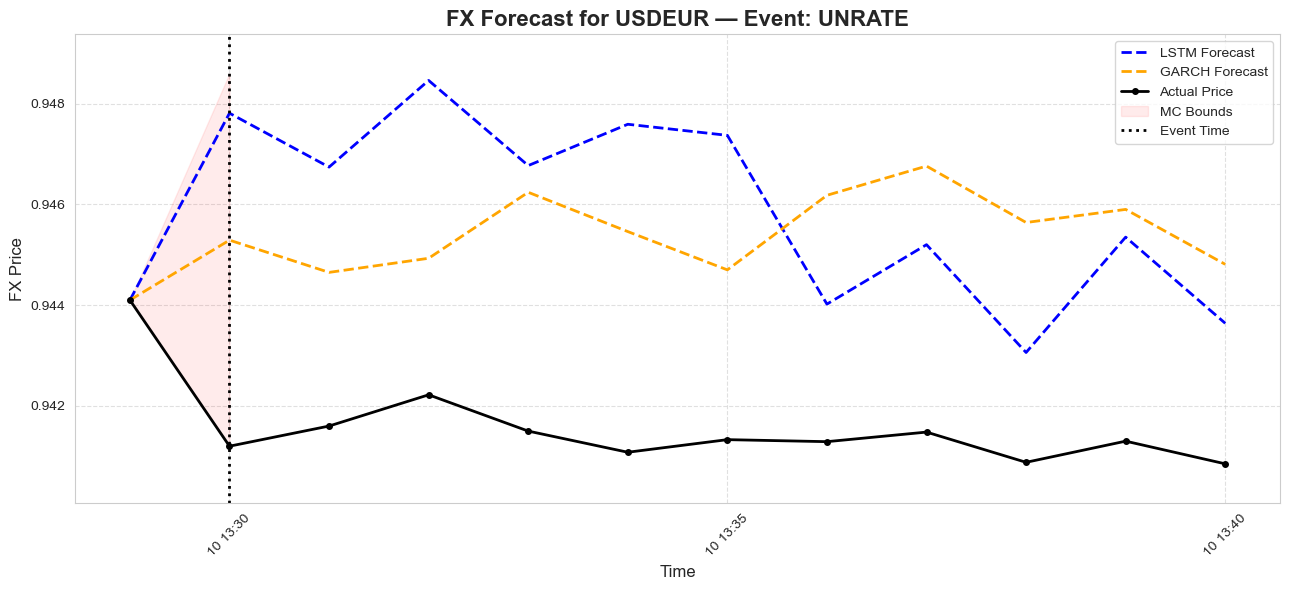

In [47]:
# Each row: [AdjClose, Volume, VWAP, Volatility, AvgVol, Ticker, Expected, Actual, Surprise]
raw_input = np.array([
    [0.94436, 149, 0.9442, 0.000169441, 0.000143645, "UNRATE", 3.4, 3.6, 0.2],
    [0.94417, 117, 0.9443, 0.000201215, 0.000143645, "UNRATE", 3.4, 3.6, 0.2],
    [0.94425, 115, 0.9441, 0.0000847,  0.000143645, "UNRATE", 3.4, 3.6, 0.2],
    [0.94428, 165, 0.9442, 0.0000318,  0.000143645, "UNRATE", 3.4, 3.6, 0.2],
    [0.94410, 197, 0.9441, 0.00019064, 0.000143645, "UNRATE", 3.4, 3.6, 0.2]
], dtype=object)

# Actual prices for test
actual_prices = [0.9441, 0.9412, 0.9416, 0.94222, 0.9415, 0.94108, 0.94133, 0.94129, 0.94148, 0.94088, 0.9413, 0.94085]

# Call the function
combined_df = combine_fx_event_predictions(
    pair_fx="USDEUR",
    start_datetime_str="10/03/2023 13:30",
    ticker="UNRATE",
    expected=3.4,
    actual=3.6,
    final_data=final_data,
    raw_input=raw_input,
    results=results
)

# Display dataframe and plot
display(combined_df)
plot_fx_forecasts(combined_df, actual_prices)

### Bounds test results

In [50]:
# Call the function
df_with_bounds, bounds_stats = check_mc_bounds_on_all_events(final_data)

# Display the dataframe with the 130 events (only their event minute) along with the bounds and events info
display(df_with_bounds)

# Display information about events within and outside the bounds 
display(bounds_stats)

,USDEUR_AdjClose,USDGBP_AdjClose,USDCNH_AdjClose,Ticker,Expected,Actual,USDEUR_bounds,USDGBP_bounds,USDCNH_bounds
0,0.94120,0.83101,6.95208,UNRATE,3.4,3.6,"(0.9412, 0.9486)","(0.83101, 0.83713)","(6.95017, 6.96622)"
1,0.93092,0.82010,6.86558,CPI,0.4,0.4,"(0.92911, 0.9357)","(0.81752, 0.82443)","(6.86558, 6.87911)"
2,0.92297,0.81367,6.86955,INTR,5.0,5.0,"(0.92284, 0.92909)","(0.81262, 0.81949)","(6.86211, 6.87709)"
3,0.91608,0.80800,6.88211,GDP,2.7,2.6,"(0.91563, 0.91648)","(0.80768, 0.80842)","(6.8792, 6.88318)"
4,0.91917,0.80799,6.86970,PCE,0.3,0.3,"(0.91822, 0.91986)","(0.80742, 0.80879)","(6.86852, 6.8737)"
...,...,...,...,...,...,...,...,...,...
125,0.96137,0.80433,7.26893,INTR,4.5,4.5,"(0.956, 0.96247)","(0.79975, 0.80652)","(7.25317, 7.269)"
126,0.96073,0.80398,7.26677,GDP,2.6,2.3,"(0.95908, 0.95997)","(0.80312, 0.80386)","(7.26257, 7.26677)"
127,0.96316,0.80535,7.29443,PCE,0.3,0.3,"(0.96135, 0.96306)","(0.80457, 0.80592)","(7.29195, 7.29746)"
128,0.96484,0.80369,7.29015,UNRATE,4.1,4.1,"(0.96085, 0.96841)","(0.8005, 0.8064)","(7.28708, 7.30392)"


,Within_Bounds,Above_Bounds,Below_Bounds,Total_Evaluated,Within bounds %
USDEUR,120,5,5,130,0.92
USDGBP,120,5,5,130,0.92
USDCNH,120,5,5,130,0.92


---------

### Evaluation of LSTM 

In [155]:
# def evaluate_kpis(results_dict):
#     evaluation = []

#     for pair, result in results_dict.items():
#         y_pred = np.array(result['preds'])
#         y_true = np.array(result['actuals'])
#         price_scaler = result['price_scaler']

#         print(f"{pair} → {len(y_pred)} events used for prediction")

#         def inverse_transform(seq):
#             return price_scaler.inverse_transform(seq.reshape(-1, 1)).flatten()

#         y_pred_inv = np.array([inverse_transform(seq) for seq in y_pred])
#         y_true_inv = np.array([inverse_transform(seq) for seq in y_true])

#         y_p1 = y_pred_inv[:, 0]
#         y_a1 = y_true_inv[:, 0]

#         mae_1 = mean_absolute_error(y_a1, y_p1)
#         rmse_1 = mean_squared_error(y_a1, y_p1, squared=False)
#         mape_1 = np.mean(np.abs((y_a1 - y_p1) / y_a1)) * 100
#         r2_1 = r2_score(y_a1, y_p1)
#         prev = y_a1[0]  # last known price (at t = -1)
#         da_1 = np.mean(np.sign(y_a1[1:] - prev) == np.sign(y_p1[1:] - prev))

#         mae_all = mean_absolute_error(y_true_inv.flatten(), y_pred_inv.flatten())
#         rmse_all = mean_squared_error(y_true_inv.flatten(), y_pred_inv.flatten(), squared=False)
#         mape_all = np.mean(np.abs((y_true_inv.flatten() - y_pred_inv.flatten()) / y_true_inv.flatten())) * 100
#         r2_all = r2_score(y_true_inv.flatten(), y_pred_inv.flatten())
#         da_all = np.mean([
#             np.mean(np.sign(y_true_inv[:, i][1:] - y_true_inv[:, i][:-1]) == np.sign(y_pred_inv[:, i][1:] - y_pred_inv[:, i][:-1]))
#             for i in range(y_true_inv.shape[1])
#         ])

#         evaluation.append({
#             'pair': pair,
#             'MAE_t+1': round(mae_1,4),
#             'RMSE_t+1': round(rmse_1,4),
#             'MAPE_t+1': round(mape_1,4),
#             'R2_t+1': round(r2_1,4),
#             'DA_t+1': round(da_1,4),
#             'MAE_avg': round(mae_all,4),
#             'RMSE_avg': round(rmse_all,4),
#             'MAPE_avg': round(mape_all,4),
#             'R2_avg': round(r2_all,4),
#             'DA_avg': round(da_all,4)
#         })

#     return pd.DataFrame(evaluation)

In [157]:
def evaluate_kpis(results_dict):
    evaluation = []

    for pair, result in results_dict.items():
        y_pred = np.array(result['preds'])  # shape: (n_events, forecast_horizon)
        y_true = np.array(result['actuals'])  # shape: (n_events, forecast_horizon)
        inputs = result['inputs']  # list of (1, sequence_len, num_features)
        price_scaler = result['price_scaler']
        features = result['features']

        print(f"{pair} → {len(y_pred)} events used for prediction")

        # Inverse transform predictions and actuals
        def inverse_transform(seq):
            return price_scaler.inverse_transform(seq.reshape(-1, 1)).flatten()

        y_pred_inv = np.array([inverse_transform(seq) for seq in y_pred])
        y_true_inv = np.array([inverse_transform(seq) for seq in y_true])

        # Get last known price from each input sequence (t = -1)
        adjclose_idx = features.index(f'{pair}_AdjClose')
        last_known_prices = np.array([
            price_scaler.inverse_transform([[inp[0, -1, adjclose_idx]]])[0, 0]
            for inp in inputs
        ])

        # t+1 KPIs
        y_p1 = y_pred_inv[:, 0]
        y_a1 = y_true_inv[:, 0]

        mae_1 = mean_absolute_error(y_a1, y_p1)
        rmse_1 = mean_squared_error(y_a1, y_p1, squared=False)
        mape_1 = np.mean(np.abs((y_a1 - y_p1) / y_a1)) * 100
        r2_1 = r2_score(y_a1, y_p1)

        actual_dir = np.sign(y_a1 - last_known_prices)
        predicted_dir = np.sign(y_p1 - last_known_prices)
        da_1 = np.mean(actual_dir == predicted_dir)

        # Average KPIs over full forecast horizon
        mae_all = mean_absolute_error(y_true_inv.flatten(), y_pred_inv.flatten())
        rmse_all = mean_squared_error(y_true_inv.flatten(), y_pred_inv.flatten(), squared=False)
        mape_all = np.mean(np.abs((y_true_inv.flatten() - y_pred_inv.flatten()) / y_true_inv.flatten())) * 100
        r2_all = r2_score(y_true_inv.flatten(), y_pred_inv.flatten())

        # DA over full forecast horizon (each step vs t = -1)
        da_all = np.mean([
            np.mean(np.sign(y_true_inv[i] - last_known_prices[i]) == np.sign(y_pred_inv[i] - last_known_prices[i]))
            for i in range(len(y_true_inv))
        ])

        evaluation.append({
            'pair': pair,
            'MAE_t+1': round(mae_1, 4),
            'RMSE_t+1': round(rmse_1, 4),
            'MAPE_t+1': round(mape_1, 4),
            'R2_t+1': round(r2_1, 4),
            'DA_t+1': round(da_1, 4),
            'MAE_avg': round(mae_all, 4),
            'RMSE_avg': round(rmse_all, 4),
            'MAPE_avg': round(mape_all, 4),
            'R2_avg': round(r2_all, 4),
            'DA_avg': round(da_all, 4)
        })

    return pd.DataFrame(evaluation)

In [158]:
results_df = evaluate_kpis(results)
results_df

USDEUR → 6 events used for prediction
USDGBP → 6 events used for prediction
USDCNH → 6 events used for prediction


,pair,MAE_t+1,RMSE_t+1,MAPE_t+1,R2_t+1,DA_t+1,MAE_avg,RMSE_avg,MAPE_avg,R2_avg,DA_avg
0,USDEUR,0.0014,0.0019,0.1497,0.9521,0.5000,0.0014,0.0021,0.1536,0.9467,0.7727
1,USDGBP,0.0011,0.0015,0.1333,0.9700,0.5000,0.0036,0.0061,0.4354,0.5506,0.6515
2,USDCNH,0.0211,0.0301,0.3052,-0.0160,0.8333,0.0111,0.0165,0.1611,0.6370,0.6212


In [159]:
results

{'USDEUR': {'model': <keras.src.engine.sequential.Sequential at 0x24eebc949d0>,
  'preds': [array([0.48220643, 0.4809314 , 0.4673335 , 0.48214072, 0.46826935,
          0.477366  , 0.47974938, 0.48154843, 0.46879277, 0.4750889 ,
          0.49705926], dtype=float32),
   array([0.26689574, 0.26757398, 0.2673821 , 0.26764792, 0.26785636,
          0.26713905, 0.26821408, 0.268415  , 0.26877594, 0.2693189 ,
          0.27049506], dtype=float32),
   array([0.38282508, 0.39272857, 0.38472602, 0.38207778, 0.38765642,
          0.36900702, 0.38006875, 0.37707722, 0.3828868 , 0.39027685,
          0.3918289 ], dtype=float32),
   array([0.30343542, 0.30406958, 0.30385333, 0.30362463, 0.3042695 ,
          0.30267185, 0.30314872, 0.3034225 , 0.3044099 , 0.305027  ,
          0.3069334 ], dtype=float32),
   array([0.2943574 , 0.29596663, 0.29486308, 0.2951801 , 0.29654962,
          0.29515427, 0.2956064 , 0.29480585, 0.29702222, 0.29743755,
          0.29926232], dtype=float32),
   array([0.5436